# Chapter 12 - Hedging #
&copy; 2021 Kenneth Winston

A **`hedge`** is a strategy intended to remove or lower a source of uncertainty about the future rate of return of a portfolio or company. The ultimate hedge is the creation of a risk-free arbitrage like the ones discussed in Section 2.6, although as we noted there it's unlikely that profitable riskless arbitrages can last long.

But an old joke points out a logical problem: A patient rushes into a doctor's office and says "Doctor, I broke my arm in five places!" The doctor's prescription: "Stay out of those places."

Similarly, why would a manager need a hedging strategy to remove or lower risk? Why not just stay out of those places and avoid unwanted risks in the first place?

An answer can be found by considering the [first hedge fund](https://www.managedfunds.org/hedge-fund-investors/history/), established by Alfred Winslow Jones in 1949. It simultaneously bought and sold stocks. The idea was to hedge out the risk that the overall stock market rose or fell, while attempting to benefit from picking outperformers on the long side and underperformers on the short side. (Today this strategy is called **`market-neutral`**.) By taking positions in individual securities, Jones couldn't avoid also getting exposures to the market. The Capital Asset Pricing Model lay in the future, but Jones (and others) had a qualitative understanding that securities had market risk. To avoid that unwanted risk, Jones had to hedge it away.

This chapter will explore five reasons why managers would want to do something more complicated than staying out of those places, and the techniques that are used to implement hedging when avoidance alone won't do.

## 12.1 Risk Unbundling ##

Sometimes a financial security, a company, or other economic structure will naturally contain a package of risks, only some of which are desired.

Consider the case of Philippe, a French investor with a euro-based portfolio. Philippe wants to invest in [Tesla](https://www.tesla.com/), the American vehicle and energy company. He sees that he can easily buy US dollar-denominated shares of Tesla under the symbol [TSLA](https://www.nasdaq.com/market-activity/stocks/tsla) on the [Nasdaq exchange](https://www.nasdaq.com/about)[$^1$](#twelve_footnotes).

When Philippe buys dollar-denominated shares of Tesla, Inc., he will expose his portfolio to the unknown outcomes of the company's success or failure in electric vehicles, batteries, and solar facilities. But he will also take on currency risk: his portfolio will be exposed to the euro/dollar foreign exchange (f/x) rate since shares of TSLA bought on the Nasdaq are denominated in dollars.

Suppose that Philippe wants the company risk but not the f/x risk. That motivates him to look for an **`unbundling hedge`** that neutralizes, or at least mitigates, the f/x risk while still allowing his portfolio to participate in the company risk.

It's not hard to find such a hedge: the major world currencies trade heavily both in the **`spot market`** and the **`forward market`**. The spot market simply exchanges one currency for another "on the spot," i.e. instantaneously. The forward market locks in an exchange of currencies in the future at a rate determined today.

For Philippe's purpose, the currency forward market is ideal. If he invests in dollar-denominated Tesla shares, he'll have future dollars that he doesn't want. He'll want to convert them to euros. That's exactly what a **`currency forward`** does: it's a contract in which parties agree in advance that one currency will be sold and another bought for a currently specified price at a specified time in the future. A forward is not an option: the parties have no choice but to complete the transaction at the specified time in the future.

The future swap of currencies required by a currency forward is equivalent[$^2$](#twelve_footnotes) to buying a default-free zero-coupon bill in one currency (in this case euros, i.e. a German government bill) and selling a default-free zero-coupon bill in another currency (in this case dollars, i.e. a US Treasury). Recall from Section 11.2.4 that Germany sets the benchmark default-free rates in the Eurozone, so German government debt is used here even though Philippe is a French investor.

Thus a currency forward is itself a bundle consisting of two components that are similar to (but not actually) (1) US Treasury bills and (2) German government bills. Philippe's side of the forward consists of borrowing dollars at the US T-bill rate to buy euros at the German government bill rate. Another party &mdash; Philippe's counterparty &mdash; borrows euros at the German government bill rate and buys dollars at the US T-bill rate. In $T$ years Philippe will get the matured value of the German bill in euros; simultaneously he will need to pay back the matured value of the US Treasury bill in dollars. Philippe's counterparty will do the mirror transactions.[^3](#twelve_footnotes)

Let $r_{f}$ be the default-free rate on US Treasury bills (in dollars); the "f" subscript here means "foreign" (to Philippe). Let $r_{d}$ ("d" for "domestic") be the default-free rate on German government bills (in euros). Let $(f/d)_0$ be the spot exchange rate, i.e. the current number of dollars required to buy a euro.

Using the continuous discounting convention, a zero-coupon German government bill worth &euro;1 in $T$ years will cost &euro;$exp(-r_d T)$ now. Thus the current price in dollars to buy the zero-coupon German government bill is $(f/d)_0exp(-r_d T)$.

The current price in dollars to buy a zero-coupon US Treasury bill worth $\$1$ in $T$ years is $\$exp(-r_f T)$. This allows us to solve for $\text{fwd}$, the number of US zeros required to buy a German zero:
$$\text{fwd}\cdot exp(-r_fT)=(f/d)_0{exp}(-r_d T)\label{eq:forward_equiv}\tag{12.1}$$

$\text{fwd}$ is called the **`forward rate`**; it is the equalizer that makes future dollars ("f" or foreign currency) equal to future euros ("d" or domestic currency) today. Put another way, the forward rate is the rate that causes the cost of entering into a currency forward to be exactly balanced so that neither the buyer of foreign nor the seller of foreign has an advantage; the time-$0$ market value of the currency forward is zero. As time goes on and f/x and interest rates change, one party or the other will benefit and the other party will be disadvantaged.

Making the notation more explicit, we have
$$\text{fwd}(f,d,T)=(f/d)_0exp\bigl((r_f-r_d)T\bigr)\label{eq:forward_rate}\tag{12.2}$$

Suppose that Philippe wants to invest &euro;$10,000$ in dollar-denominated TSLA as of the most recent yearend, and that he wants to hedge out $T=1$ year of currency movements. The next code segment retrieves the three inputs to \eqref{eq:forward_rate} and computes $\text{fwd}(f,d,T)$.

In [1]:
import pandas as pd
import qrpm_funcs as qf
import numpy as np
from datetime import datetime
import ssl

#Get exchange rates and US riskfree rates
lastday=qf.LastYearEnd()
seriesnames=['DEXUSEU','DGS1']
cdates,ratematrix=qf.GetFREDMatrix(seriesnames,enddate=lastday)
print("As of:",cdates[-1])
usd_per_euro=ratematrix[-1][0]
rt1_us=ratematrix[-1][1]
print("    Spot dollars per euro (f/d) %.4f" % usd_per_euro)
print("    US 1-year rate rf %.4f" % rt1_us)

#Put end-of-month exchange rates in dataframe for later use
df_fx_d = pd.DataFrame(np.array(ratematrix)[:,0], \
                     index=[datetime.strptime(cd,"%Y-%m-%d") for cd in cdates], \
                     columns=[seriesnames[0]])
#Drop NaNs and save only monthends
df_fx=df_fx_d.dropna().resample('M').last()
#Form log-returns; negative means dollar strengthened
#so it is ln((f/d)1/(f/d)0) where f is dollar d is euro
df_fx=np.log(df_fx).diff().dropna()

#Problem with Bundesbank's certificate - drop verification
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

#Read one-year rates from Bundesbank
bundesbank_url = "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId="
bundesbank_url += "BBSIS.M.I.ZST.ZI.EUR.S1311.B.A604.R01XX.R.A.A._Z._Z.A&"
bundesbank_url += "its_csvFormat=en&its_fileFormat=csv&mode=its"
df_csv = pd.read_csv(bundesbank_url,skiprows=4)
df_german = df_csv.rename(index=str, columns={df_csv.columns[0]: "Date", \
                                              df_csv.columns[1]: "Rate"})
#Check latest
bundesbank_lastdate=df_german['Date'].iloc[-1]
if bundesbank_lastdate >= lastday[:7]:
    rt1_german=df_german.loc[df_german['Date'] == lastday[:7]]["Rate"].iloc[0]
    bundesbank_lastdate = lastday[:7]
else: #Bundesbank hasn't yet updated rates to last day of previous year. Mach Schnell!
    rt1_german=df_german["Rate"].iloc[-1]

print("    German 1-year rate rd %.4f" % rt1_german,"as of",bundesbank_lastdate)

#Calculate currency forward price per (12.12)
time=1
fwd_price=usd_per_euro*np.exp((rt1_us-rt1_german)*time/100.)
print("\n    1yr forward dollars per euro %.4f" % fwd_price)

As of: 2020-12-31
    Spot dollars per euro (f/d) 1.2230
    US 1-year rate rf 0.1000
    German 1-year rate rd -0.7300 as of 2020-12

    1yr forward dollars per euro 1.2332


Table 12.1 below shows Philippe's hedging strategy given these numbers. He takes &euro;$10,000$ and converts it to dollars at the spot rate. He simultaneously enters into a currency forward which sells that number of dollars forward for one year and buys the equivalent amount of euros forward for one year. Here "buy forward" or "sell forward" means to buy (sell) a one-year zero-coupon government bill that is currently worth the given amount.

In [2]:
euro_invested=10000.
euro_forward=euro_invested*np.exp(rt1_german/100*time)
usd_invested=euro_invested*usd_per_euro
usd_forward=usd_invested*np.exp(rt1_us/100*time)

def show_currency_forward_table(title):

    print(title)
    print("Item      |        Dollars (USD=f)       |       Euros (EUR=d)     |        Ratio")
    print("-"*90)
    print("Time 0    |", \
         "          {:8,.1f}".format(usd_invested), \
         "          |        {:8,.1f}".format(euro_invested), \
          "        | Spot USD/EUR {:6,.4f}".format(usd_per_euro))
    print("1yr rfree |", \
         "          {:8,.3f}".format(rt1_us), \
         "          |        {:8,.3f}".format(rt1_german), \
          "        |")
    print("Time 1    |", \
         "          {:8,.1f}".format(usd_forward), \
         "          |        {:8,.1f}".format(euro_forward), \
          "        |  Fwd USD/EUR {:6,.4f}".format(fwd_price))

show_currency_forward_table("Table 12.1: Hedging EUR 10,000")

Table 12.1: Hedging EUR 10,000
Item      |        Dollars (USD=f)       |       Euros (EUR=d)     |        Ratio
------------------------------------------------------------------------------------------
Time 0    |           12,230.0           |        10,000.0         | Spot USD/EUR 1.2230
1yr rfree |              0.100           |          -0.730         |
Time 1    |           12,242.2           |         9,927.3         |  Fwd USD/EUR 1.2332


Philippe will convert euros to dollars as shown at time zero. He will invest the dollars in dollar-denominated shares of Tesla, Inc. At time one, his currency forward will automatically convert dollars back to euros as shown.

To see how the hedge works, suppose that over the year horizon two things happen:
- Tesla, Inc.'s business is successful and dollar-denominated TSLA goes up $20\%$; but
- The dollar crashes to ${$}5/$&euro;.

Philippe may think that the crash of the dollar is irrelevant to him as a euro-based investor since he hedged dollars vs. euros. But Table 12.2 extends Table 12.1 to summarize the full accounting:

In [3]:
show_currency_forward_table("Table 12.2: Hedging plus gain")

#Calculations for Philippe's investment in TSLA
#under dollar-crash/TSLA up scenario
underlying_dollar_appreciation=.2
new_usd_per_euro=5
new_tsla_value=usd_invested*(1+underlying_dollar_appreciation)
unhedged_tsla_gain_usd=new_tsla_value-usd_forward
unhedged_tsla_gain_euro=unhedged_tsla_gain_usd/new_usd_per_euro
final_euro_total=euro_forward+unhedged_tsla_gain_euro

print("T=1 TSLA  |", \
      "          {:8,.1f}".format(new_tsla_value), \
      "          |                        ", \
      "|              {:6,.4f}".format(underlying_dollar_appreciation))
print("T=1 Unhdgd|", \
     "          {:8,.1f}".format(unhedged_tsla_gain_usd), \
     "          |        {:8,.1f}".format(unhedged_tsla_gain_euro), \
     "        |Crash USD/EUR {:6,.4f}".format(new_usd_per_euro))
print("Final amt |", \
     "                  ", \
     "          |        {:8,.1f}".format(final_euro_total), \
     "        | Final return {:6,.4f}".format(final_euro_total/euro_invested-1.))
print("No hedge  |", \
     "          {:8,.1f}".format(new_tsla_value), \
     "          |        {:8,.1f}".format(new_tsla_value/new_usd_per_euro), \
     "        |Final no hdg {:6,.4f}".format( \
                        (new_tsla_value/new_usd_per_euro)/euro_invested-1.))


Table 12.2: Hedging plus gain
Item      |        Dollars (USD=f)       |       Euros (EUR=d)     |        Ratio
------------------------------------------------------------------------------------------
Time 0    |           12,230.0           |        10,000.0         | Spot USD/EUR 1.2230
1yr rfree |              0.100           |          -0.730         |
Time 1    |           12,242.2           |         9,927.3         |  Fwd USD/EUR 1.2332
T=1 TSLA  |           14,676.0           |                         |              0.2000
T=1 Unhdgd|            2,433.8           |           486.8         |Crash USD/EUR 5.0000
Final amt |                              |        10,414.0         | Final return 0.0414
No hedge  |           14,676.0           |         2,935.2         |Final no hdg -0.7065


Had Philippe not hedged at all, his dollar-based TSLA investment would have been mutilated by the crash of the dollar, losing $1-.24(\$/€)_0$, or around $70\%$, of its value. But he didn't escape without bruises: he did not receive anywhere near the $20\%$ rate of return that dollar-based investors got.

These bruises were the result of underhedging. His currency forward covered the increase in dollars that would have occurred if he had invested in a US Treasury bill, but he actually invested in TSLA. If Philippe had somehow known at the beginning of his year investment period that TSLA would be up $20\%$, he could have bought a currency forward that would have exactly covered his dollar gain, giving him
$$10,000\frac{(f/d)_0\cdot1.2}{\text{fwd}(f,d,T)}=12,000exp\bigl(r_€-r_{$}\bigr)$$
euros at the end of the year. He still wouldn't have gotten a $20\%$ rate of return because euro rates are lower than dollar rates, but he would have been close. 

But in fact Philippe had no way of knowing TSLA's risky future: if he had hedged anticipating a $20\%$ rise in TSLA but had actually experienced a $20\%$ drop with a radical strengthening of the dollar to $.2$ per euro, he would have ended up owing money:
$$10,000\cdot(f/d)_0\bigl(\frac{1.2}{\text{fwd}(f,d,T)}-\frac{1.2-.8}{.2}\bigr)<0$$
Guessing is not a good hedging strategy.

## 12.1.1 Quantity-adjusting options ##

Suppose Philippe wants to hedge the risk of the first scenario we described above: TSLA appreciates more than Treasurys in dollars. At time $0$, Philippe wants to enter into a contingent trade that, if necessary, sells his excess (over Treasury) dollars at time $T$ in exchange for euros at the forward rate $\text{fwd}(f,d,T)$ rather than at the new spot rate $(f/d)_T$. Like the currency forward, this hedge can be advantageous (if dollars weaken) or disadvantageous (if dollars strengthen). Either way, it removes uncertainty about the future.

The sale of the excess dollars can be accomplished with a familiar instrument: a "plain vanilla" dollar-denominated European[$^4$](#twelve_footnotes) call option on the underlying TSLA. We discussed these instruments in Section 9.2.1. Let $X_t$ be the dollar value of the underlying risky asset TSLA at time $0\leq t\leq T$; in our example $X_0=10000(f/d)_0$. Writing (selling) a call option with time-$T$ payoff
$$max(X_T-K_f,0)\quad\text{where}\quad K_f=X_0exp(r_fT)\label{eq:quanto_dollar_payoff}\tag{12.10}$$
will neutralize any dollars over $K_f$, the amount covered by the currency forward discussed above.

The pricing of such options was also discussed in Section 9.2.1. Under the assumption that the underlying asset follows a lognormal random walk, the price of the option is given by the Black-Scholes formula (9.3)\eqref{eq:black_scholes}. Adapted to the current notation, that is
$$C(X_0,K_f,T,r_f,\sigma_X)=X_0N(d_1)-K_fexp(-r_fT)N(d_2)$$
$$\text{where}\label{eq:black_scholes_for_quanto}\tag{12.11}$$
$$d_1=\frac{ln\bigl(\frac{X_0}{K_f}\bigr)+\bigl(r_f+\frac{\sigma_X^2}{2}\bigr)T}{\sigma_X\sqrt{T}}\quad\text{and}\quad d_2=d_1-\sigma_X\sqrt{T}$$
Here $r_f$ is the annual risk-free rate in dollars and $\sigma_X$ is the annualized volatility of TSLA log-returns. Philippe will receive the amount given by \eqref{eq:black_scholes_for_quanto} in exchange for writing an option that gives away his excess dollars.

What about the other side of the transaction described in the first paragraph of this section: receiving euros at the forward rate rather than at the new spot rate? Philippe would like to purchase (at time $0$) a derivative with time-$T$ euro (domestic) payoff
$$\frac{max(X_T-K_f,0)}{\text{fwd}(f,d,T)}\label{eq:quanto_euro_payoff}\tag{12.12}$$

Such a derivative would lock in the time-$0$ forward rate despite the fact that at the time it's needed &mdash; at time $T$ &mdash; a new f/x rate will prevail. This derivative is called a **`quantity-adjusting`**, or **`quanto`** call option.

For notational simplicity, we'll price a quanto call with euro payoff equal to \eqref{eq:quanto_dollar_payoff}, i.e. with a locked-in exchange rate of $1$. Philippe will buy $\frac{1}{\text{fwd}(f,d,T)}$ such quantos to get the desired payoff \eqref{eq:quanto_euro_payoff}.

The price of the quanto call option, depends on two stochastic variables: $X_T$, the value of the underlying; and $(f/d)_T$, the future f/x rate. While the future f/x rate is not explicitly referenced in \eqref{eq:quanto_dollar_payoff}, it needs to be referenced in order to understand the cost of converting the dollar (foreign) amount to the fixed euro (domestic) amount at time $T$.

The quanto call price can be derived using the assumption of joint lognormality ($X_T$ and $(f/d)_T$) and a continuous arbitrage approach similar to Black-Scholes.[$^5$](#twelve_footnotes) The pricing formula for the quanto call with euro payoff $max(X_T-K_f,0)$ is:
$$QuantoCall=X_0exp(-qT)N(d_{+})-K_fexp(-r_dT)N(d_{-})$$
$$\text{where}\label{eq:quanto_call_price}\tag{12.13}$$
$$d_{\pm}=\frac{ln\bigl(\frac{X_0}{K_f}\bigr)+\bigl(r_d-q\pm\frac{\sigma_X^2}{2}\bigr)T}{\sigma_X\sqrt{T}}\quad\text{and}\quad q=r_d-r_f-\rho\sigma_X\sigma_R$$
Notation summary (example in parentheses):
- $f$ is foreign currency (dollars)
- $d$ is domestic currency (euros)
- $X_t$ is the foreign currency price of the underlying at time $t$ (TSLA)
- $T$ the horizon of the option (1 year)
- $N()$ is the standard normal cdf
- $r_f$ and $r_d$ are default-free rates in the respective currencies for horizon $T$
- $K_f$ is the foreign currency strike price $(X_0exp(r_fT))$
- $R_t=(f/d)_t$ is the exchange rate of foreign per domestic at time $t$
- $\sigma_X$ is the annualized volatility of log-returns of the underlying
- $\sigma_R$ is the annualized volatility of log-returns of the exchange rate
- $\rho$ is the correlation between $ln(X)$ and $ln(R)$

Note that setting $f=d$ removes the currency adjustment and forces $r_f=r_d$ and $q=0$. In that case \eqref{eq:quanto_call_price} becomes the same as Black-Scholes \eqref{eq:black_scholes_for_quanto}.

To hedge the second situation described above &mdash; TSLA drops in dollar price &mdash; Philippe could buy $\frac{1}{\text{fwd}(f,d,T)}$ **`quanto puts`** with time-$T$ euro payoff:
$$max(K_f-X_T,0)\label{eq:quanto_put_payoff}\tag{12.14}$$
He would simultaneously sell an ordinary dollar-denominated European put option with the same time-$T$ payoff \eqref{eq:quanto_put_payoff} &mdash; but in dollars, not in euros.

\eqref{eq:quanto_dollar_payoff} and \eqref{eq:quanto_put_payoff} show that buying a quanto put and simultaneously selling a quanto call has a linear time-$T$ payoff pattern in euros:
$$X_T+QuantoPut_T-QuantoCall_T=K_f$$
Here the quantities $X_T$ and $K_f$ which are nominally in foreign (dollars) are converted to domestic (euros) at a $1:1$ exchange rate. The RHS is non-stochastic; $K_f$ is a known quantity at time $0$. The LHS is a portfolio of three items: buy foreign (dollar)-denominated underlying TSLA and convert to euros at $1:1$; buy quanto put; sell quanto call. Since the time-$T$ value of that portfolio is a nonstochastic domestic (euro) amount, the portfolio must be equivalent to a domestic (euro) risk-free instrument. This gives a quanto put-call parity relationship that holds at any time $0\leq t\leq T$:
$$X_t+QuantoPut_t-QuantoCall_t=exp(-r_d(T-t))K_f\label{eq:quanto_parity}\tag{12.15}$$
\eqref{eq:quanto_parity} is the quanto equivalent of (8.1)\eqref{put_call_conversion}. 

Using put-call parity \eqref{eq:quanto_parity}, the price of a quanto put is:
$$QuantoPut=-X_0\bigl(1-exp(-qT)N(d_{+})\bigr)+K_fexp(-r_dT)N(-d_{-})\label{eq:quanto_put_price}\tag{12.16}$$

The following code segment summarizes the key inputs for Philippe's quanto hedging strategy:

In [4]:
#Parameter calculations for dollar/euro TSLA quanto
import yfinance as yf
#https://github.com/ranaroussi/yfinance

tsla = yf.Ticker("TSLA")
df_tsla=tsla.history(period="max")   #Prices are adjusted
df_tsla=df_tsla.resample('M').last()
#Form log-returns
df_tsla=pd.DataFrame(np.log(df_tsla["Close"]).diff().dropna())

# Join underlying and currency
df_join=df_tsla.join(df_fx).dropna()

print("Data from",df_join.index[0].strftime("%Y-%m-%d"),"to", \
      df_join.index[-1].strftime("%Y-%m-%d"))
#Current price of underlying in foreign currency
X_0=usd_invested
print("            Current price of underlying X_0: %.2f" % X_0)
print("                             Time horizon T: %f" % time)
print("                 Domestic riskfree rate r_d: %.4f" % rt1_german)
print("                  Foreign riskfree rate r_f: %.4f" % rt1_us)
print("          Foreign currency strike price K_f: %.2f" % usd_forward)

#Annualized standard deviations
sigma_X=df_join.std()["Close"]*np.sqrt(12.)
sigma_R=df_join.std()[df_fx.columns[0]]*np.sqrt(12.)
print("Annualized volatility of underlying sigma_X: %.4f" % sigma_X)
print("  Annualized volatility of f/x rate sigma_R: %.4f" % sigma_R)
#Correlation
rho=df_join.corr().iloc[0,1]
print("     Correlation between underlying and f/x: %.4f" % rho)

Data from 2010-07-31 to 2020-12-31
            Current price of underlying X_0: 12230.00
                             Time horizon T: 1.000000
                 Domestic riskfree rate r_d: -0.7300
                  Foreign riskfree rate r_f: 0.1000
          Foreign currency strike price K_f: 12242.24
Annualized volatility of underlying sigma_X: 0.5657
  Annualized volatility of f/x rate sigma_R: 0.0863
     Correlation between underlying and f/x: 0.1642


With these inputs, the cost of Philippe's hedging strategy can be computed in each direction: underlying up and underlying down.

In [5]:
import scipy.stats as spst

#Prices of quanto call and quanto put
def quanto_call(X_0,T,r_f,r_d,K_f,sigma_X,sigma_R,rho):
    #returns price of quanto call from (12.23)
    #Variables have to be positive
    if X_0<=0 or T<=0 or K_f<=0 or sigma_X<0 or sigma_R<0:
        return(0)
    q=r_d-r_f-rho*sigma_X*sigma_R
    d_plus=(np.log(X_0/K_f)+(r_d-q+sigma_X**2/2)*T)/(sigma_X*np.sqrt(T))
    d_minus=d_plus-sigma_X*np.sqrt(T)
    #Get cumulative normals
    n_of_d_plus=spst.norm.cdf(d_plus)
    n_of_d_minus=spst.norm.cdf(d_minus)
    qc=X_0*np.exp(-q*T)*n_of_d_plus-K_f*np.exp(-r_d*T)*n_of_d_minus
    return(qc)

def quanto_put(X_0,T,r_f,r_d,K_f,sigma_X,sigma_R,rho):
    #compute price of quanto put from (12.25)
    #calls quanto_call and uses put-call parity
    qc=quanto_call(X_0,T,r_f,r_d,K_f,sigma_X,sigma_R,rho)
    qp=qc-X_0+np.exp(-r_d*T)*K_f
    
    return(qp)

#Compute example quanto call value
q_c = quanto_call(X_0, time, rt1_us/100., rt1_german/100., usd_forward, \
            sigma_X, sigma_R, rho)
#Scale by 1/fwd
q_c/=fwd_price
print("              Buy Quanto call: %.2f" % q_c)

#Compute example plain vanilla call value
bs_c = quanto_call(X_0, time, rt1_us/100., rt1_us/100., usd_forward, \
            sigma_X, 0., 0.)
print("       Write Dollar-only call: %.2f" % bs_c)

up_cost=q_c-bs_c
print("  Cost of hedging TSLA upside: %.2f" % up_cost)

#Compute example quanto put value
q_p = quanto_put(X_0, time, rt1_us/100., rt1_german/100., usd_forward, \
            sigma_X, sigma_R, rho)
#Scale by 1/fwd
q_p/=fwd_price
print("\n             Write Quanto put: %.2f" % q_p)

#Compute example plain vanilla put value
bs_p = quanto_put(X_0, time, rt1_us/100., rt1_us/100., usd_forward, \
            sigma_X, 0., 0.)
print("          Buy Dollar-only put: %.2f" % bs_p)

down_cost=bs_p-q_p
print("Cost of hedging TSLA downside: %.2f "% down_cost)
total_cost=up_cost+down_cost
print("\n        Total cost of hedging: %.2f" % total_cost)

              Buy Quanto call: 2276.39
       Write Dollar-only call: 2723.54
  Cost of hedging TSLA upside: -447.15

             Write Quanto put: 2359.04
          Buy Dollar-only put: 2723.54
Cost of hedging TSLA downside: 364.49 

        Total cost of hedging: -82.66


Note that the dollar-only call and the dollar-only put have the same price. This is because of put-call parity and the fact that we have set $K_f=exp(r_fT)X_0$. For the dollar-only options we have $r_f=r_d=r_{$}$. That means $exp(-r_dT)K_f=X_0$ in this case, forcing $QuantoPut=QuantoCall$.

Also note that the cost of hedging is negative! That's because the correlation between TSLA and the dollar/euro exchange rate is low, while TSLA's volatility is high. TSLA's high volatility means that the dollar-only options have high premia. The low correlation between TSLA and dollars-per-euro means that there is a comparatively high probability of TSLA up/dollar strengthens or TSLA down/dollar weakens; these are the scenarios where it would have been better not to hedge. That makes the quanto premia relatively less valuable than the dollar-only premia.

Unfortunately for Philippe, there is no regular market for dollar-euro-TSLA quantos. There are only a few quanto instruments that trade regularly. The best known is the [Nikkei 225 future](https://www.cmegroup.com/education/featured-reports/nikkei-225-spread-opportunities.html) trading on the [CME (formerly Chicago Mercantile Exchange)](https://www.cmegroup.com/). Investors can buy futures on the [Nikkei 225 Index](https://indexes.nikkei.co.jp/en/nkave/) that pay the dollar amount of the Japanese yen-denominated index. For example, if the Nikkei 225 is worth &yen;$20,000$, the Nikkei 225 dollar future will pay $\$20,000$.

Philippe's dollar-euro-TSLA quantos would be bespoke (custom-built) instruments, and a notional size of &euro;$10,000$ would not be enough to induce a financial institution to create these instruments just for Philippe. So in practice, Philippe would have to use a dynamically adjusted portfolio of dollars and TSLA to try to replicate the behavior of the quantos.

In summary, unbundling hedging requires some thought. The efficacy of a strategy to remove a particular risk from a package of risks depends on understanding the relationships between wanted and unwanted risks.

## 12.2 Franchise Preservation ##

A second type of hedging aims at **`franchise preservation`**, where a company wants to neutralize risks that are outside of its area of expertise or control. For example, aluminum is lighter than steel so automobile companies purchase aluminum to provide lighter car bodies and engines. If the price of aluminum skyrockets, an automobile company may not be able to pass on costs to its customers fast enough and may find itself unprofitable. Thus the automobile company may buy aluminum futures covering its next year's worth of aluminum purchases so it can stabilize the prices it charges.

For a detailed example to illustrate franchise preservation hedging, we'll return to Philippe, the French (euro-based) investor who wanted to hedge the US dollar exposure he took on when he bought dollar-base Tesla, Inc. Let's suppose that when Philippe is not dabbling in the stock market, he owns a business that imports California wines into France.[$^{6,7}$](#twelve_footnotes)

Informed by his recent experience with cross-currency investing, Philippe begins to worry about the currency risk to the Philippe Wine Company ("PWC") franchise. The company has an overall budget of &euro;$20,000,000$ per year. It converts euros to dollars at the current exchange rate and buys California wines with dollars; it then imports them to France and sells them for euros at a $10\%$ markup. But Philippe now realizes that if the dollar strengthens significantly, PWC will be squeezed: he won't be able to raise euro prices because he is competing with French (and other European) wine producers, but he'll be paying more.

Table 12.3 summarizes PWC's business:

In [6]:
pwc_french_euro_budget=20000000.
french_bottle_cost=10.
us_bottle_cost=french_bottle_cost*usd_per_euro
french_bottle_sales_price=french_bottle_cost*1.1
pwc_num_imported=pwc_french_euro_budget/french_bottle_cost

print("Table 12.3: Philippe Wine Company Summary")
print("Location     |       France")
print("CEO          |       Philippe")
print("Import budget| EUR {:12,.1f}".format(pwc_french_euro_budget))
print("Cost/bottle  |    USD {:7.4f}".format(us_bottle_cost))
print("Sales price  |    EUR {:7.4f}".format(french_bottle_sales_price))
print("Num imported |     {:12,.1f}".format(pwc_num_imported))

print("\nT=0 USD/EUR  |    USD {:7.4f}".format(usd_per_euro))
print("Cost/bot, lcl|    EUR {:7.4f}".format(french_bottle_cost))
print("Profit       |    EUR {:12,.1f}". \
      format(pwc_num_imported*(french_bottle_sales_price-french_bottle_cost)))

fx_bad=us_bottle_cost/french_bottle_sales_price
print("\nBad USD/EUR  |    USD {:7.4f}".format(fx_bad))
print("Cost/bot, lcl|    EUR {:7.4f}".format(us_bottle_cost/fx_bad))
print("Profit       |    EUR {:12,.1f}".format(0))

Table 12.3: Philippe Wine Company Summary
Location     |       France
CEO          |       Philippe
Import budget| EUR 20,000,000.0
Cost/bottle  |    USD 12.2300
Sales price  |    EUR 11.0000
Num imported |      2,000,000.0

T=0 USD/EUR  |    USD  1.2230
Cost/bot, lcl|    EUR 10.0000
Profit       |    EUR  2,000,000.0

Bad USD/EUR  |    USD  1.1118
Cost/bot, lcl|    EUR 11.0000
Profit       |    EUR          0.0


Philippe considers engaging in a hedging program similar to the one that was outlined for his cross-currency investment in TSLA. But he would rather build a business that is naturally immune to the franchise risk of currency movements.

So he decides to split his company in half. The first half will be the original PWC that imports US wines to France, but with half the original budget. The new second half will be a subsidiary that imports French wines to the US. This will provide natural diversification; the French subsidiary will do well (poorly) on a strong (weak) euro; while the American subsidiary will do poorly (well) on a strong (weak) euro. Philippe is optimistic that he can mitigate franchise currency risk without elaborate trading strategies.

He calls his friend Ken in the US and explains the situation to him, and asks Ken to be the head of the American subsidiary. He tells Ken that the original &euro;$20,000,000$ budget will be split in half and converted to dollars so that Ken's subsidiary can purchase and import French wines.

The new company, the Philippe Ken Wine Company ("PKWC") will thus initially be split evenly between the two countries as shown in Table 12.4:

In [7]:
#Calculations for Philippe-Ken Wine Company

def display_company_stats(new_rate,title):

    french_euro_budget=10000000.
    french_bottle_cost=10.
    us_bottle_cost=french_bottle_cost*usd_per_euro
    us_usd_budget=french_euro_budget*usd_per_euro
    french_bottle_sales_price=french_bottle_cost*1.1
    us_bottle_sales_price=us_bottle_cost*1.1

    print(title)
    print("Location     |       France      |       USA        |    Total")
    print("CEO          |       Philippe    |       Ken        |")
    print("Import budget| EUR {:12,.1f}".format(french_euro_budget), \
          " | USD {:12,.1f}".format(us_usd_budget),"|")
    print("Cost/bottle  |    USD {:7.4f}".format(us_bottle_cost), \
          "   |    EUR {:7.4f}".format(french_bottle_cost),"  |")
    print("Sales price  |    EUR %.4f" % french_bottle_sales_price, \
      "   |    USD %.4f" % us_bottle_sales_price,"  |")

    print("\n")
    local_french_cost=us_bottle_cost/new_rate
    local_us_cost=french_bottle_cost*new_rate
    french_bottles=french_euro_budget*new_rate/us_bottle_cost
    us_bottles=us_usd_budget/new_rate/french_bottle_cost
    total_bottles=french_bottles+us_bottles
    french_pandl=french_bottles*(11-us_bottle_cost/new_rate)
    us_pandl=us_bottles*(us_bottle_sales_price-french_bottle_cost*new_rate)
    total_pandl=french_pandl+us_pandl/new_rate

    print("USD/EUR      |    %.4f" % new_rate,"        |                  |")

    print("Cost/bot lcl |    EUR {:7.4f}".format(local_french_cost), \
          "   |    USD {:7.4f}".format(local_us_cost),"  |")
    print("Num imported |     {:12,.1f}".format(french_bottles), \
      " |     {:12,.1f}".format(us_bottles), \
      "|    {:12,.1f}".format(total_bottles))
    print("Profit       |  EUR{:12,.1f}".format(french_pandl), \
      " |  USD{:12,.1f}".format(us_pandl), \
      "| EUR{:12,.1f}".format(total_pandl))

#Show table at current exchange rate
display_company_stats(usd_per_euro, \
                "Table 12.4: Philippe-Ken Wine Company: unchanged f/x")

Table 12.4: Philippe-Ken Wine Company: unchanged f/x
Location     |       France      |       USA        |    Total
CEO          |       Philippe    |       Ken        |
Import budget| EUR 10,000,000.0  | USD 12,230,000.0 |
Cost/bottle  |    USD 12.2300    |    EUR 10.0000   |
Sales price  |    EUR 11.0000    |    USD 13.4530   |


USD/EUR      |    1.2230         |                  |
Cost/bot lcl |    EUR 10.0000    |    USD 12.2300   |
Num imported |      1,000,000.0  |      1,000,000.0 |     2,000,000.0
Profit       |  EUR 1,000,000.0  |  USD 1,223,000.0 | EUR 2,000,000.0


Philippe and Ken now calculate what might happen to PKWC in the situation that Philippe feared: a strong dollar. Naturally they expect the volume and profit of the French half of the business to suffer, but the American subsidiary should do well. Their intuition tells them that the overall business should end up pretty much unscathed by the change in exchange rate:

In [8]:
display_company_stats(1.0,"Table 12.5: Philippe-Ken Wine Company: strong dollar")

Table 12.5: Philippe-Ken Wine Company: strong dollar
Location     |       France      |       USA        |    Total
CEO          |       Philippe    |       Ken        |
Import budget| EUR 10,000,000.0  | USD 12,230,000.0 |
Cost/bottle  |    USD 12.2300    |    EUR 10.0000   |
Sales price  |    EUR 11.0000    |    USD 13.4530   |


USD/EUR      |    1.0000         |                  |
Cost/bot lcl |    EUR 12.2300    |    USD 10.0000   |
Num imported |        817,661.5  |      1,223,000.0 |     2,040,661.5
Profit       |  EUR-1,005,723.6  |  USD 4,223,019.0 | EUR 3,217,295.4


In fact, as Table 12.5 shows, the PKWC franchise does better than "unscathed." The results after currency movement are actually better than the original results. The volume of bottles handled by the business have gone up to more than the original 2 million shown in Table 12.4, and the profit has increased over the original &euro;2 million.

Philippe and Ken feel that this seems too good to be true. They were just hoping to stay even by diversifying, but they're actually improving. Perhaps there was something inadvertently asymmetric about the new PKWC structure; maybe they'll do worse if the dollar weakens. Table 12.6 shows that scenario.

In [9]:
display_company_stats(1.5,"Table 12.6: Philippe-Ken Wine Company: weak dollar")

Table 12.6: Philippe-Ken Wine Company: weak dollar
Location     |       France      |       USA        |    Total
CEO          |       Philippe    |       Ken        |
Import budget| EUR 10,000,000.0  | USD 12,230,000.0 |
Cost/bottle  |    USD 12.2300    |    EUR 10.0000   |
Sales price  |    EUR 11.0000    |    USD 13.4530   |


USD/EUR      |    1.5000         |                  |
Cost/bot lcl |    EUR  8.1533    |    USD 15.0000   |
Num imported |      1,226,492.2  |        815,333.3 |     2,041,825.6
Profit       |  EUR 3,491,414.6  |  USD-1,261,320.7 | EUR 2,650,534.1


Strangely, the business has also done better in this direction: both bottle volume and profits have increased due to the weakening of the dollar.

### 12.2.1 Siegel's Paradox ###

It seems paradoxical that both non-monetary (bottle volume) and monetary metrics got better no matter which way the dollar-euro exchange rate moved in our examples. Could this be a coincidence because we just chose fortunate numbers?

It's not hard to see that this was no coincidence. Let $z=\frac{(f/d)_T}{(f/d)_0}$ be the ratio of the future (time-$T$) foreign/domestic exchange rate to the spot (time-$0$) rate. In our example, $z>1$ means the dollar weakened and $z<1$ means the dollar strengthened.

The French part of the Philippe-Ken Wine Company will import $1,000,000z$ bottles after the f/x change, while the US part of the company will import $1,000,000\frac{1}{z}$ bottles. So total PKWC bottle volume will be
$$1,000,000\bigl(\frac{1}{z}+z\bigr)$$
[Jensen's Inequality](https://doi.org/10.1007%2FBF02418571) gives
$$\frac{1}{2}exp(y)+\frac{1}{2}exp(-y)\geq exp(0)=1$$
since exp is convex; multiply both sides by $2$ and set $y=ln(z)$ to get
$$z+\frac{1}{z}\geq2$$
Thus total PKWC bottle volume will be strictly larger than $2,000,000$ if $z\neq1$; *any* f/x rate change will increase the company's volume.

Figure 12.1 shows the number-of-bottles response curve:

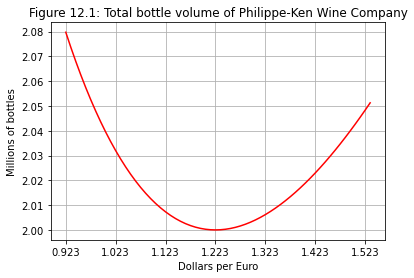

In [10]:
#Show number-of-bottles curve for Siegel's paradox
%matplotlib inline
import matplotlib.pyplot as plt

x=np.arange(usd_per_euro-.3,usd_per_euro+.3+.01,.01)
z=x/usd_per_euro
y=z+1/z

i=np.arange(len(x))
plt.plot(i,y,color='red')
plt.xticks(i[::10],[str(round(float(label), 3)) for label in x[::10]])
plt.xlabel("Dollars per Euro")
plt.ylabel("Millions of bottles")
plt.title("Figure 12.1: Total bottle volume of Philippe-Ken Wine Company")
plt.grid()
plt.show()

Before changes to f/x rates, PKWC annual profits were &euro;2,000,000 as shown in Table 12.4. Once again letting $z=\frac{(f/d)_T}{(f/d)_0}$ be the ratio of post-change exchange rate to original exchange rate, company profits in euros look like this:
$$\frac{1,000,000}{z}\bigl(\frac{11}{z}-10\bigr)+1,000,000z\bigl(11-\frac{10}{z}\bigr)\label{eq:euro_profit}\tag{12.18}$$

The first summand is the contribution of the US subsidiary to profits as a product of number of bottles imported times converted-to-euro profit per bottle. The US business's costs are fixed at &euro;10 per bottle. Its proceeds are fixed in dollars at $\$11(f/d)_0$, but the proceeds are variable at &euro;$\frac{11}{z}$ when converted back to euros.

Similarly, the second summand is the contribution of the French part of PKWC to profits. The French proceeds per bottle are fixed at &euro;$11$, but the cost in euros is variable at &euro;$\frac{10}{z}$ per bottle.

Manipulating \eqref{eq:euro_profit} into a polynomial gives
$$\frac{1,000,000}{z^2}(z+1)(11z^2-21z+11)\label{eq:euro_profit_poly}\tag{12.19}$$

The roots of the quadratic in \eqref{eq:euro_profit_poly} are imaginary, so profits are positive as long as $z$ is positive, which it must be. Thus the combined PKWC franchise never loses money, alleviating Philippe's original concern.

While the franchise never loses money, it can make less money than the original &euro;$2,000,000$ profit enjoyed by the undiversified PWC, or by PKWC before f/x rate changes. Subtracting \eqref{eq:euro_profit_poly} from &euro;$2,000,000$, we see that PKWC dips below the original profit level when
$$(z-1)(11z^2-z-11)<0\label{eq:lower_euro_profits}\tag{12.20}$$

The next code segment finds the roots of the quadratic and translates to actual exchange rates:

In [11]:
#More Siegel's Paradox calculations
#Roots of quadratic in (12.20)
a_poly=11
b_poly=-1
c_poly=-11
discriminant=b_poly**2-4*a_poly*c_poly

low_root=(-b_poly-np.sqrt(discriminant))/(2*a_poly)
high_root=(-b_poly+np.sqrt(discriminant))/(2*a_poly)
print("Roots of (12.20) polynomial:",low_root,1,high_root)

print("Profit less than original between (f/d)=",usd_per_euro, \
      "and",high_root*usd_per_euro)

#minimum profit location
min_root=(4+np.sqrt(158/3))/11
print("Minimum profit at z=",min_root,"(f/d)=",min_root*usd_per_euro)

#minimum profit amount
min_profit=1000000*(min_root+1)*(11-21*min_root+11*min_root**2)/min_root**2
print("Minimum hedged profit",min_profit)
profit_giveup_percent=100.-min_profit/20000.
print("Percentage profit giveup at minimum: %.2f" % profit_giveup_percent)
#Compute unhedged profit at that point
print("Unhedged (PWC) profit at minimum hedged profit:",20000000*(1.1*min_root-1))

Roots of (12.20) polynomial: -0.9555779793429654 1 1.0464870702520563
Profit less than original between (f/d)= 1.223 and 1.279853686918265
Minimum profit at z= 1.0233800320326436 (f/d)= 1.2515937791759233
Minimum hedged profit 1988770.9045979201
Percentage profit giveup at minimum: 0.56
Unhedged (PWC) profit at minimum hedged profit: 2514360.7047181595


When the new/old exchange rate ratio $z$ is between $1$ and $1.0465$, the hedged franchise PKWC makes a little less than the unhedged enterprise, with a minimum at $z=1.02338$.The profit at that point is &euro;$1,988,771$, only $56$bps below the original franchise profit of &euro;$2,000,000$.

If Philippe had kept the entire &euro;$20,000,000$ in France importing California wine at $\$11.227$ and selling it for &euro;$11$, his cost per bottle would be &euro;$\frac{10}{z}$, so he would buy $2,000,000z$ bottles. He sells each one for &euro;$11$, so his profit would be &euro;$20,000,000(1.1z-1)$.

Figure 12.2 compares the France-only franchise PWC's profits with the diversified franchise PKWC's profits. Figure 12.3 zooms in on the profits around the neighborhood of the time-0 exchange rate:

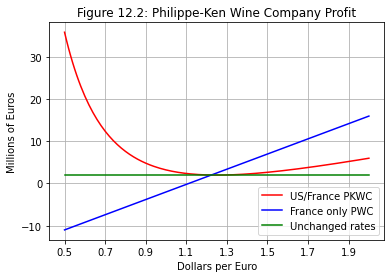

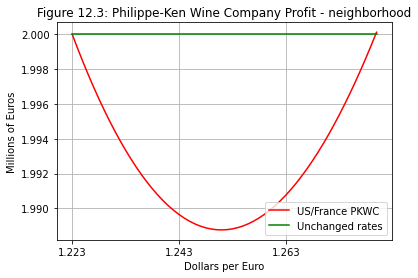

In [12]:
#Show profitability graphs for Siegel's paradox -
#Philippe-Ken Wine Company

#Broad range and narrow range
x=np.arange(.5,2.01,.01)
title_str="Figure 12.2: Philippe-Ken Wine Company Profit"

for graph_no in [1,2]:

    z=x/usd_per_euro
    y_hedged=[(zz+1)*(11-21*zz+11*zz**2)/zz**2 for zz in z]  #(12.29)
    y_unhedged=20*(1.1*z-1)
    y_constant=[2]*len(y_hedged)

    i=np.arange(len(x))
    plt.plot(i,y_hedged,color='red',label='US/France PKWC')
    if graph_no==1:
        plt.plot(i,y_unhedged,color='blue',label='France only PWC')
    plt.plot(i,y_constant,color='green',label='Unchanged rates')
    plt.xticks(i[::20],[str(round(float(label), 3)) for label in x[::20]])
    plt.xlabel("Dollars per Euro")
    plt.ylabel("Millions of Euros")
    plt.legend(loc='lower right')
    plt.title(title_str)
    plt.grid()
    plt.show()

    #next iteration
    x=np.arange(usd_per_euro,high_root*usd_per_euro+.001,.001)
    title_str="Figure 12.3: Philippe-Ken Wine Company Profit - neighborhood"

Figure 12.2 shows that the franchise preservation strategy is successful. The original France-only franchise (PWC, blue line) looks more like a currency business than a wine importing business. It is at the mercy of exchange rates. The diversified franchise (PKWC, red line) is positively convex as a result of \eqref{eq:euro_profit_poly} and is almost always above the original &euro;$2,000,000$ profit line in green.

Figure 12.3 shows that for a small neighborhood around the time-0 f/x rate, the diversified franchise gives up a little profit &mdash; at most $56$bps as we saw above. This seems a small price to pay for protection against potentially ruinous large currency moves.

While this exploration provides yet another hearty endorsement of the power of diversification, it doesn't explain the apparent paradox of positive convexity in Figures 12.2 and 12.3. If any change at all in exchange rates increases both non-monetary volume (number of bottles) and monetary profits, then it would appear that we've found the key to unlimited prosperity. World governments need merely work with each other to whip their exchange rates into a volatile frenzy. That will cause more wine, more [Tesla Model Ss](https://www.tesla.com/models), and more [Airbus 380s](https://www.airbus.com/aircraft/passenger-aircraft/a380.html) to appear effortlessly.

That idea is manifestly absurd. But the number-of-bottle and profit formulas are correct, so what prevents this absurd idea from working? The apparent paradox has a name, as the title of this subsection indicates: [Siegel's Paradox](https://doi.org/10.2307/1880565). In 1972, [Jeremy Siegel](https://fnce.wharton.upenn.edu/profile/siegel) noted that Jensen's Inequality gives rise to certain counterintuitive phenomena concerning exchange rates.

The logical fallacy that gives rise to the "paradox" comes in the assumption that economic participants don't change their behavior. This is the kind of fallacy discussed in Chapter 2, where phenomena like Goodhart's Law and the Lucas Critique were different versions of a similar underlying dynamic: people react.

If the euro strengthens, Philippe buys more California wine. The California wine producers will eventually respond to the increased demand by raising prices &mdash; perhaps not for the several thousand extra bottles in our example, but in aggregate to all the increased demand for American goods due to the changed f/x rates. Before they change prices in response to higher demand, the wine producers who produce the extra bottles are economic losers because they have not yet responded to market forces.

But the [Law of Demand](https://www.econlib.org/library/Enc/Demand.html) is as close to an immutable physical law as there is in economics. Eventually prices will adjust. Thus Siegel's Paradox is a result of myopic vision. If we only look at the Philippe-Ken Wine Company and ignore all the other economic participants, it looks like PKWC wins no matter what. But American or French wine producers lose (gain) because they are working harder (less hard) for less (more) real money. In aggregate all we have done by changing f/x rates is shift wealth from one country to another in a way that may be quickly counteracted by adjusting prices.

In fact in an era of [floating exchange rates](https://www.imf.org/external/np/exr/ib/2000/062600.htm), the change in f/x rates was probably a response to, and not a cause of, shifting wealth and other factors like interest rates, balance of trade, and national debt.

Thus the Philippe-Ken Wine Company has not fully eliminated risk, as the assumptions about unchanging same-currency wine prices are unrealistic. Still, the diversified franchise is clearly a more resilient business than the undiversified franchise.

### 12.2.2 Modigliani-Miller and franchise hedging ###

In a 1958 paper, [Franco Modigliani and Merton Miller](https://www.jstor.org/stable/1809766) developed what is sometimes called the **`Modigliani-Miller Indifference Theorem`**. [Miller](https://www.nobelprize.org/prizes/economic-sciences/1990/miller/biographical/) received a Sveriges Riksbank Prize in Economic Sciences in Memory of Alfred Nobel in 1990 for this work. [Modigliani](https://www.nobelprize.org/prizes/economic-sciences/1985/modigliani/biographical/), who was previously cited in Section 2.3.2, was a 1985 recipient of the same prize. Their 1958 work states that the cost of capital of a firm (as defined below) is independent of &mdash; indifferent to &mdash; the proportion of debt in its capital structure.

Modigliani and Miller define cost of capital as the ratio of two quantities. The denominator is the current market value $V_0$ of the enterprise (including debt and equity) as first defined in Section 9.5.1. The numerator is $\mathbb{E}[V_T]-V_0$, the expected monetary return on the enterprise over some horizon $T$. The Modigliani-Miller Indifference Theorem (Proposition I of their cited paper) states that under assumptions of perfect frictionless markets, $\frac{\mathbb{E}[V_T]-V_0}{V_0}$ is invariant to changes in the proportion of debt vs. equity in $V_0$.

With perfect frictionless markets, an investor can create a portfolio by (1) buying equity shares of a company; and (2) borrowing or lending. This portfolio is a synthetic version of the original company with more or less debt than the original company. Modigliani and Miller show with a no-arbitrage argument that the synthetic company's cost of capital $\frac{\mathbb{E}[V_T]-V_0}{V_0}$ must be the same as the original company's cost of capital. Their use of a no-arbitrage argument allowed them to avoid making assumptions about risk preferences.

Following Modigliani and Miller, many researchers pursued other forms of inside-outside indifference. If an investor outside a company can synthetically create a different debt-equity ratio by making adjustments outside the company, can't the investor make other adjustments outside the company? Hedging is just such a potential adjustment.

At the beginning of this section, we pointed out that automobile companies are exposed to the risk of volatile aluminum prices. But in the spirit of Modigliani-Miller, investors can buy [aluminum companies](https://www.alcoa.com/global/en/what-we-do/aluminum/default.asp) as well as automobile companies. If an investor is worried about aluminum price effects on an automobile company in his or her portfolio, s/he can just add an aluminum company to the portfolio in an appropriate proportion to offset the risk.

If aluminum goes down in price, the investor's aluminum company will do worse but the car company will do better because its materials will be cheaper. If aluminum goes up in price, the car company will suffer but the aluminum company will make up for it. If the automobile company hedges aluminum, that could confuse investors who might become overhedged, thereby re-establishing an unwanted exposure to aluminum. Thus, some argue that it's best to leave hedging to the end investor.

This line of reasoning ignores what academics disapprovingly call "imperfections," by which they mean the ways in which reality commits insubordination by refusing to obey academic assumptions. Transactions costs, taxes, and bankruptcy are real-world considerations that violate the pure Modigliani-Miller axioms and invalidate the irrelevance theorem. If aluminum prices change so dramatically that the automobile company has to declare bankruptcy, there will be a discontinuous loss of value: the value of a car company as a going concern is greater than just the auction value of its plant and equipment. As we saw in Chapter 11, recovery given default is only around $40\%$. Thus companies rightly attach a high value to self-preservation.

In practice, franchise preservation hedging involves gamesmanship and prediction of future outcomes. If all but one of a group of competitive automobile companies hedge aluminum, then the non-hedger may go bankrupt if aluminum prices skyrocket. But if aluminum prices crash, the non-hedger will have a big competitive advantage over its rivals who have locked in the old higher prices. The non-hedger might drive some of the hedgers into bankruptcy by its ability to lower automobile prices.

This dynamic played out in the gold mining industry starting in the 1980s. Some gold mining companies argued that they were good at mining, but that they couldn't control the price of gold. During the 1980s and 1990s, many (but not all) gold miners hedged the price of gold in order to purify their reliance on their own skill in driving down mining costs while avoiding the external risk of fluctuating gold prices.

By 1999, [Ashanti Goldfields](https://www.anglogoldashanti.com/) (a large Ghanian gold miner) had sold forward a large portion of its reserves at at a locked-in price. Gold prices then spiked up, meaning that Ashanti owed money on its hedges while its gold reserves got more valuable. By definition "reserves" are in the ground; Ashanti could only mine about $15\%$ a year of the gold it had hedged. The bankers demanding cash payment on the hedges were very much above the ground. Ashanti was able to negotiate with its creditors to avoid outright bankruptcy, but [shareholder value was decimated](https://www.ghanaweb.com/GhanaHomePage/features/ASHANTI-A-Hedge-Too-Far-21933).

This and other bad outcomes of gold hedging programs caused the industry fashion to shift. A 2006 academic paper by [Tim Adam and Chitru Fernando](https://doi.org/10.1016/j.jfineco.2005.03.014) argued that gold hedging was profitable because gold miners were uniquely able to reap the risk premium ("contango") usually found in the gold futures market. But this argument did not stay the course of the gold industry: currently gold miners have [virtually no gold hedges](https://www.vaneck.com/insights/blogs/gold-investing/gold-hedging-a-precious-lesson-learned).

To preserve their franchises, companies generally hedge the relative risk, not the absolute risk, of price shocks to their inputs. This is similar to benchmark-relative risk discussed in section 4.1.6: here the benchmark is the industry. If almost everyone in the industry is exposed to aluminum prices because no one hedged, then they might all raise or lower prices together if necessary due to aluminum shocks. Aluminum shocks confer no competitive advantage or disadvantage in that case: in that case a hedger is taking the most risk. Similarly if almost everyone hedges, then a non-hedger is taking the most risk. There's only a potential problem (or reward) for a company that has a very different risk profile from its competitors. Since the potential reward from being different is probably not due to skill &mdash; automobile companies are not aluminum traders &mdash; it is usually not one that companies want to embrace.

Empirical evidence of the effect of franchise preservation hedging on actual franchise value is mixed. [Allayannis and Weston 2001](https://doi.org/10.1093/rfs/14.1.243) concluded that f/x hedging added a statistically significant $5\%$ to the value[$^8$](#twelve_footnotes) of firms that hedged. Despite this, [a survey](https://www.cfo.com/risk-management/2013/10/half-companies-hedging-currency-risks/) showed that only about half of multinational firms engaged in currency hedging: perhaps some of them felt that, like PKWC, they were naturally hedged.

On the other hand, [Jin and Jorion 2006](https://doi.org/10.1111/j.1540-6261.2006.00858.x) studied 119 oil and gas producers and analyzed 330 firm-years worth of hedging oil prices; gas prices; neither; or both. They did not find any significant effect of hedging on firm market value, but they did find that hedging lowered the hedging firm's stock price sensitivity to price movements of the hedged commodity.

In addition to investigating the effectiveness of franchise preservation hedging, scholars have investigated hedging rationale. In a 2018 paper, [Geyer-Klingeberg, Hang, Rathgeber, St&ouml;ckl, and Walter](https://doi.org/10.1007/s40685-017-0052-0) summarized dozens of previous studies that had investigated reasons to hedge. They found four main reasons for franchise preservation hedging:
1. reducing the corporate tax burden;
2. lowering bankruptcy and financial distress costs;
3. mitigating asymmetric information and agency costs of equity;[$^9$](#twelve_footnotes); and
4. improving the coordination of financing and investment policy while alleviating agency conflicts of debt.

None of these reasons are directly observable, but there are observable proxy variables: for example tax-loss carryforwards on the balance sheet proxy for "reducing the corporate tax burden." Geyer-Klingeberg et. al. find find weak evidence for reasons 1 and 4 (taxes and financing coordination), and no evidence for reason 3 (mitigating asymmetric information). But they do find strong evidence for reason 2, lowering bankruptcy and financial distress costs. Thus franchise preservation hedging does seem to be a key activity in corporations.

### 12.2.3 Bank franchise hedging  ###

For banks, franchise preservation hedging is a matter of urgency.

Deposits in banks are short-term: a checking account depositor can remove its money at any time. Such monies are called **`demand deposits`** and are ultra-short-term liabilities of the bank. Banks do have longer-lasting deposits and do borrow money for longer periods, but demand deposits are usually a key source of funding.

Theoretically a bank could make money simply by accepting deposits and charging fees for transactions and storage. Banks would then just be electronic warehouses, and would always be able to repay their depositors instantaneously. But in fact banks are not electronic warehouses: they use most of their customers' funds to form a portfolio of risky investments like loans and securities. This portfolio's returns accrue to the bank and its shareholders, not to the bank's customers. A warehouse-only bank would have to charge such high fees that it would not be able to attract customers from banks who don't have to make a profit from warehousing.

Table 12.7 shows a simplified "T-account" statement for [JP Morgan Chase & Co.](https://www.jpmorganchase.com/corporate/investor-relations/annual-report-proxy.htm),  as of December 31, 2020, summarizing its assets and liabilities

Table 12.7 | JP Morgan Chase T-account statement December 31, 2020 (\$Mn) |
------------- | ----------------------- |

| Assets | &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; | Liabilities | &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; |
|:----|----:|:----|----:|
| Cash & Equivs | $914,396$  | Deposits | $2,144,157$ |
| Securities  | $1,253,760$ | Short-term | $663,197$ |
| Loans  | $984,525$ | Long-term | $299,263$ |
| Other | $233,390$ | Stk equity | $279,354$ |
| Tot Assets | $3,386,071$ | Total Liabs | $3,386,071$ |

On the right side of the balance sheet, deposits and short-term liabilities are dominant. On the left side, securities and loans are dominant. This creates a potentially dangerous **`asset-liability mismatch`**.

Because of this danger, banks are [heavily regulated](https://www.occ.treas.gov/). One requirement is that banks must act as partial, or fractional, warehouses. They are required by national authorities to keep some minimum fraction of their customers' deposits in reserve, ready to pay back customers demanding their money back. This practice is called **`fractional reserve banking`**. For large banks in the US, the minimum reserve fraction was $10\%$ until March 26, 2020. At that point reserve requirements were [lowered to zero](https://www.federalreserve.gov/monetarypolicy/reservereq.htm) on an emergency basis as a result of the COVID-19 pandemic.

The unreserved fraction of deposits and other bank liabilities is loaned out or invested at higher rates than depositors are paid. And, as in Table 12.7, bank assets usually have significantly longer maturities than their liabilities. Most of the time &mdash; about $89\%$ of the time as we saw in Chapter 3 &mdash; this is a naturally profitable position as yield curves tend to be upward-sloping. The rates on the longer-term assets then tend to be higher than the rates on the shorter-term liabilities. But even more than that, banks charge a significant spread: the rate a depositor is paid to loan money to the bank for $x$ years is considerably lower than the rate the bank is paid to loan money to borrowers for the same $x$ years.

There are two problems with the mismatch between long asset maturities and short liability maturities.
1. The possibility of a **`run on the bank`**: short-term depositors might all show up at the same time and demand their money back. This hasn't happened much recently for reasons we'll discuss below, but there were limited bank runs in the US at [IndyMac Bank in 2008](https://www.fdic.gov/bank/individual/failed/indymac.html) and in the UK at [Northern Rock in 2007](https://www.bankofengland.co.uk/-/media/boe/files/speech/2017/ten-years-on-lessons-from-northern-rock.pdf).
2. The possibility of yield curve movement that overwhelms the bank's spread, making their liabilities more expensive than their assets.

We first consider <b>bank runs</b>. Before the COVID-19 crisis, US banks were required to keep $10\%$ of the amount of customer deposits in reserve, i.e. in unencumbered cash warehoused and ready to repay customers. Normally far fewer than $10\%$ of depositors show up on any given day wanting to retrieve their money, so this is normally more than enough. But suppose that more then $10\%$ of the deposits were demanded for withdrawal by customers. What would the bank do after it exhausted its reserves?

The bank may have used some of the unreserved money to make mortgage loans lasting $30$ years to people buying houses. These people may be fully creditworthy and may be faithfully making the required payments on their mortgages, but there is no mechanism by which a bank can force accelerated repayment. Stretching out payments over time is the very point of long-term borrowing. As we'll see later in this chapter, for residential mortgages the right to accelerated repayment rests with the borrower and not with the lender.

Unable to retrieve the money from the borrower, the bank would have to try to sell the mortgage to a more patient investor who can wait $30$ years to receive all the scheduled cash flows. But it might take time to arrange a sale at a fair price. The fact that the bank is desperate to sell the mortgage in order to raise cash immediately (a "fire sale") will depress the price. Similarly, the fire sales of other long-term assets will depress the bank's asset-to-liability ratio, thereby lowering confidence in the bank and incenting more depositors to run to the bank to get their money out before the bank is not able to pay them back. That causes more fire sales of assets until the bank, which might have been perfectly solvent before its depositors panicked, fails. Figure 12.4 shows a crush of panicked depositors trying to get their money out of Northern Rock in 2007.

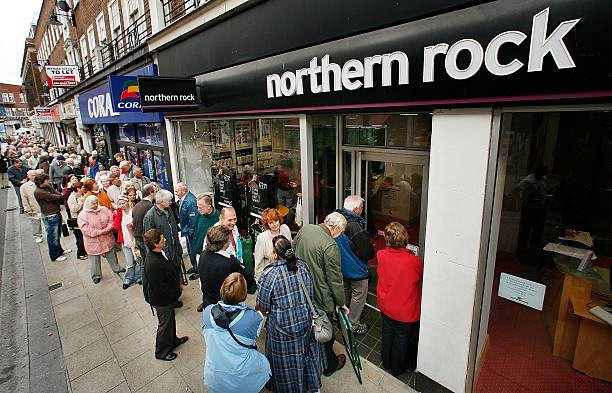
Figure 12.4 Northern Rock run in 2007

The classic paper on bank runs is a 1983 work by [Douglas Diamond and Philip Dybvig](https://doi.org/10.1086/261155). Diamond & Dybvig point out that there are two equilibria with respect to depositor confidence in banks: a calm equilibrium in which depositors expect that withdrawals are random and uncorrelated; and a turbulent equilibrium in which depositors expect that other depositors have lost faith in the bank and are rushing to take their money out. In the calm equilibrium there is no reason for a depositor to take its money out other than its own liquidity needs; in the turbulent equilibrium there is every reason for a depositor to take its money out as soon as possible before the bank runs out of money.

Diamond and Dybvig note that general poor economic conditions, rumors, or actual disturbing bank-specific news can trigger a transition from the calm equilibrium to the panicked, turbulent equilibrium. Once the regime switch is made, the bank is doomed as it becomes rational for each depositor to panic. Legally the bank has the right to suspend withdrawals, but such a step will be fatal to future confidence in the bank and damaging to trust in the general financial system.

Diamond and Dybvig showed that there is only one way to prevent a switch into the doomed equilibrium: the [Hobbes Leviathan](https://www.gutenberg.org/files/3207/3207-h/3207-h.htm#link2H_4_0407) of government intervention. Only the assurance of inexhaustibly deep pockets can remove the incentive to panic. This idea was recognized in practice 50 years before the Diamond and Dybvig paper: the [US Federal Deposit Insurance Corp ("FDIC")](https://www.fdic.gov/about/history/) was formed in 1933. So both Diamond & Dybvig theory and practical experience bear out the conclusion that there is no way for a bank to hedge itself against bank runs: it must appeal to the higher power of government backing.

Systems of government intervention to prevent bank runs vary from country to country. The US system collects an [insurance payment from each bank](https://www.fdic.gov/deposit/insurance/assessments/proposed.html) based on an assessment of the bank's size and risk level. Depositors are insured up to $\$250,000$ per account. The insurance payments go into a Deposit Insurance Fund that amounted to about $1.3\%$ of the total amount being insured as of June 2020; this percentage is called the [reserve ratio](https://www.fdic.gov/news/financial-institution-letters/2020/fil20090.html). The June 2020 reserve ratio was below the statutory minimum 1.35% due to the COVID-19 pandemic; the FDIC's studies showed that about $2\%$ would have been required to withstand past banking shocks. The insurance provided to depositors is backed by the "full faith and credit" of the US government, so if the Deposit Insurance Fund were to run out, the US Treasury would have to step in.

In practice bank failure in the US has become routine: about five banks fail each year, on average. Typically government regulators like the FDIC will swoop in over a weekend and move deposit accounts of a failed bank to a stronger bank in the area, so that on Monday morning depositors can go about their business at a new address. The shareholders of the failed bank will probably lose all or virtually all their investment, and creditors (landlords, bondholders, e.g.) might get only partial payment. But depositors will suffer no loss up to the insured amount, so they will have no reason to panic.

In the UK, a less formal system of government backing prevailed going into the Global Financial Crisis. Deposits were only guaranteed up to &pound;2,000; beyond that there was a misguided policy of "constructive ambiguity." British policymakers thought that it would be good to maintain some mystery about government backing as (they thought) that would incent depositors to be extra careful about where they deposited their money. But depositors are not bank examiners; they generally assume that a government-licensed bank is solid.

Confusion over exactly what the government was going to do led to the chaotic scene shown in Figure 12.4. The Chancellor of the Exchequer &mdash; essentially the British taxpayer &mdash; did eventually (on September 17, 2007) guarantee Northern Rock deposits. A year later, far larger bank failures of RBS and Lloyds led to even deeper raids on the British taxpayer's pocket.

Subsequently the UK adopted quite detailed bank stabilization and resolution regimes intended to avoid ambiguity, constructive or otherwise. Among other measures, a [Financial Services Compensation Scheme](https://www.bankofengland.co.uk/prudential-regulation/authorisations/financial-services-compensation-scheme) was adopted that insured deposits up to &pound;85,000 per account, or &pound;170,000 for joint accounts.

Both theory and practice have borne out Diamond & Dybvig's two-equilibrium model: it's not possible for banks to stop runs without some kind of government backing. However some resilience is better than none. In 2013, the [Basel III international banking regulatory framework](https://www.bis.org/bcbs/basel3.htm) adopted requirements for a [Liquidity Coverage Ratio](https://www.bis.org/publ/bcbs188.pdf) requiring banks to hold a stock of high-quality liquid assets in order to lower the chances of a switch into the panicked equilibrium. While fractional reserve banking will never be free of the potential for runs, the requirement to hold more assets that can be easily converted to cash can help ward off some problems.

### 12.2.4 Asset-Liability Management: interest rate swaps ###

The second asset-liability mismatch problem is the <b>possibility of yield curve movement that overwhelms the bank's spread</b>.

At any point in time a bank will make sure that it lends at higher rates than it borrows. If short-term default-free rates are $1\%$ and long-term default-free rates are $2\%$, a bank might make a 20-year loan at $3.5\%$, taking advantage both of the steepness of the yield curve and its ability to add a spread. But once the $3.5\%$ rate has been established, the bank is stuck with it for 20 years. Meanwhile demand deposit rates are resetting overnight, and other short-term rates are resetting frequently. If short-term default-free rates rise to $4\%$ at any time in the next 20 years, the $3.5\%$ loan becomes unprofitable. At the same time, the rise in short-term rates may be accompanied by a rise in long-term rates, which causes the existing fixed-rate loans and bonds owned by the bank to be discounted more and to drop in value.

In the early 1980s, hundreds of [savings and loans](https://www.federalreservehistory.org/essays/savings_and_loan_crisis)  (a type of bank) went bankrupt in the US, largely due to rapid rises in interest rates and the resulting asset-liability mismatch. Savings and loan banks had their own government insurance entity, the Federal Savings and Loan Insurance Corp. ("FSLIC"). This proved inadequate to backstop the losses, and taxpayer assistance of about $\$124$ billion was used to clean up the mess.

Today banks are required to practice **`asset-liability management (ALM)`** so that changes in interest rates are not overwhelming. ALM seeks to protect a franchise from unfavorable yield curve reshaping. For banks, the business model consists of short-term (rapidly changing or "floating") interest rates providing funding while long-term (unchanging or "fixed") interest rates provide revenue. So banks naturally have negative positions short-term and positive positions long-term. An **`interest rate swap`** can hedge away that exposure.

A standard ("plain vanilla") interest rate swap is a contract between two parties that lasts for a predetermined time. The parties agree to swap payments at regular intervals, for example every six months, during the life of the swap. One party is the **`fixed payer`** who sends the other party (the **`fixed receiver`**) an unchanging amount, determined at inception of the swap, at every payment period. (The fixed payer owns a **`payer swap`**.) At the same payment period, the fixed receiver sends an ever-changing ("floating") amount to the fixed payer. (In fact the two parties just net the amounts and whichever party owes the greater amount sends money to the other.) The floating amount is determined by reference to the current value of a benchmark, which for the vast majority of interest rate swaps is [LIBOR](https://www.theice.com/iba/libor)[$^{10}$](#twelve_footnotes). (The fixed receiver owns a **`receiver swap`**.)

The fixed and floating sides are specified as interest rates that are translated into monetary amounts by multiplying by the size of the swap, called its **`notional amount`**. For example, suppose the notional amount is $\$1$ million; the annual fixed swap rate set at the inception of the swap is $5\%$; and at a particular six-month payment period the then-current annualized LIBOR reference rate is $4\%$. Then the fixed payer would send $\$1,000,000(.05-.04)/2=\$5,000$ to the fixed receiver, dividing the annual amount by two because the interval is six months in our example. If the LIBOR reference rate had been $6\%$ instead of $4\%$, the cash flow would have gone in the other direction, paid by the fixed receiver to the fixed payer.

LIBOR reference rates used as benchmarks for interest rate swaps are typically a little higher than default-free rates such as US Treasury or German government rates. However at times the spread between LIBOR and Treasurys can dip below zero. The next code cell produces Figure 12.5, which shows differences between LIBOR and Treasurys of different tenors.

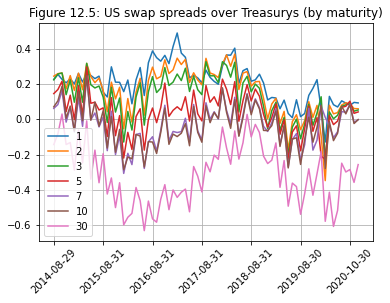

In [13]:
#Swap rates

maturities=[1,2,3,5,7,10,30]

#Swap rates
ice_base="ICERATES1100USD"
seriesnames = [ice_base + str(m) + "Y" for m in maturities]

swapdates,swapmatrix=qf.GetFREDMatrix(seriesnames,enddate=lastday)

#Treasury rates
seriesnames = ["GS" + str(m) for m in maturities]
tsydates,tsymatrix=qf.GetFREDMatrix(seriesnames,enddate=lastday)

#Swaps are daily - get monthends and check for nans
cleanswap_dates=[]
cleanswap_rates=[]
for t in range(1,len(swapmatrix)+1):
    endmonth=(t==len(swapmatrix)) or (swapdates[t][:7]!=swapdates[t-1][:7])
    if endmonth:  #have a month-end date; see if data is good
        holdrates=swapmatrix[t-1].copy()
        #back up through days of the month to find good rates
        for tt in range(1,20):
            if any(np.isnan(holdrates)):
                for m in range(len(maturities)):
                    if np.isnan(holdrates[m]):
                        holdrates[m]=swapmatrix[t-tt][m]
            else:
                cleanswap_dates.append(swapdates[t-1])
                cleanswap_rates.append(holdrates)
                break  #have a full set of swap data for this month

#FRED convention for monthly data is to show -01 as day, but it's really last day
swapspreads=[]
for t in range(len(cleanswap_dates)):
    #Change date to -01 for tsy
    tidx=tsydates.index(cleanswap_dates[t][:8]+"01")
    swapspreads.append(np.subtract(cleanswap_rates[t],tsymatrix[tidx]))
    
#show swap spreads
for m in range(len(maturities)):
    plt.plot(range(len(swapspreads)),[s[m] for s in swapspreads], \
             label=str(maturities[m]))
plt.grid()
plt.title("Figure 12.5: US swap spreads over Treasurys (by maturity)")
stride=12
plt.xticks(range(0,len(swapspreads),stride),cleanswap_dates[::stride],rotation=45)
plt.legend()
plt.show()

The 30-year line is unusual in that it shows a multi-year period during which swap rates were as much as 60bps per year lower than US Treasury rates. Banks could have arbitraged this as follows:
1. Borrow $\$100$ million at LIBOR. (LIBOR is, after all, the interbank borrowing rate.)
2. Buy $\$100$ million of US Treasurys yielding a fixed rate $\text{fix}_{30}$.
3. Enter into a 30-year payer swap at rate $SW(30)$.
4. Use the floating-rate payments received from the swap to pay the LIBOR costs of the borrowing in step 1.
5. Pocket $\$100$ million times $(\text{fix}_{30}-SW(30))$ per year.

The next code segment computes the profits from this arbitrage as of the most recent yearend.

In [14]:
# Data behind last point of swap spread curve
print("30-year Treasury rate as of ",lastday[:7],": {:.3f}".format(tsymatrix[-1][-1]))
print("30-year swap rate as of ",lastday[:7],": {:.3f}".format(cleanswap_rates[-1][-1]))
print("30-year swap spread as of ",lastday[:7],": {:.3f}".format(swapspreads[-1][-1]))
arbprofit=-1000000.*(swapspreads[-1][-1])
print("\nAnnual Profit on $100Mn arbitrage ${:,.0f}".format(arbprofit))

30-year Treasury rate as of  2020-12 : 1.670
30-year swap rate as of  2020-12 : 1.413
30-year swap spread as of  2020-12 : -0.257

Annual Profit on $100Mn arbitrage $257,000


Why was this apparently free-money riskless arbitrage not traded away? 

[Boyarchenko et. al. 2018](https://www.newyorkfed.org/research/epr/2018/epr_2018_negative-swap-spreads_boyarchenko.html) note that regulatory changes make it less attractive to do the arbitrage described above. Under post-Global Financial Crisis regulations, a bank would have to set aside risk capital to buffer any problems with the arbitrage trade. The fact that there are few foreseeable problems with the trade given the existence of CCPs does not change the fact that regulatory capital would need to be used. The fact that the negative spreads persist is evidence that banks have judged they have more profitable uses of their regulatory capital.

### 12.2.5 Interest rate swaps: simplified model ###

Just as a currency forward is basically an exchange of short-term bonds in different currencies, so an interest rate swap is basically an exchange of bonds: a fixed-rate bond is exchanged for a floating-rate bond. The two bonds have the same maturity and the same principal, so the final repayments of principal cancel out and all that is left are the periodic exchanges of coupons.

As we saw with credit default swaps in Section 11.9 and with currency forwards in Section 12.1, at the outset of an interest rate swap the fixed rate is set so that the expected values of the two bonds being exchanged are equal and the swap has no current value to either the fixed receiver or the fixed payer. Over time as rates change, one side will gain value and the other side will lose value.

In practice interest rate swaps have collateral-collection features designed to lower the risk that the losing side does not honor its obligations ("counterparty risk"). We'll work through a simplified version of an interest rate swap that ignores some of these features in order to illustrate the main exposures.

Let $SW(T)$ be the to-be-determined annual swap rate paid to the fixed receiver for a swap that starts now (time $0$) and ends $T>0$ years from now with $n$ payments received $p$ times per year (so $n/p=T$). Assume that the notional value of this swap is one monetary unit. If there are $p$ payments per year, then each payment is $SW(T)/p$. 

We will assume that swap payments are discounted at LIBOR[$^{11}$](#twelve_footnotes). Let $s(x,y)$ be the annual rate from the zero LIBOR curve that discounts a payment received at time $y>x$ back to time $x$. Using discrete compounding to discount the fixed payments back to the present gives the value of the fixed cash flows now:
$$Value(fixed,T)=\frac{SW(T)}{p}\sum_{i=1}^n \frac{1}{\bigl(1+s(0,\frac{i}{p})\bigr)^{\frac{i}{p}}}\label{eq:swap_fixed_leg}\tag{12.30}$$

The floating rate payer will pay the then-current LIBOR rate over a period $\frac{1}{p}$ years. There is a one-period offset, so the amount paid at time $\frac{i}{p}$ $(i=1,\dots,p)$ will be
$$\frac{s(\frac{i-1}{p},\frac{i}{p})}{p}$$
The expected value of the future rate can be obtained from (3.17a)\eqref{eq:implied_forward_rate_discrete}:
$$\mathbb{E}[s(\frac{i-1}{p},\frac{i}{p})]=\frac{(1+s(0,\frac{i}{p}))^{i}}{(1+s(0,\frac{i-1}{p}))^{i-1}}-1$$
Thus the expected value of the floating cash flows is
$$Value(floating,T)=\frac{1}{p}\sum_{i=1}^n 
\frac{\frac{(1+s(0,\frac{i}{p}))^{i}}{(1+s(0,\frac{i-1}{p}))^{i-1}}-1}{\bigl(1+s(0,\frac{i}{p})\bigr)^{\frac{i}{p}}}\label{eq:swap_floating_leg}\tag{12.31}$$
$$=\frac{1}{p}\sum_{i=1}^n\bigl(
\frac
{(1+s(0,\frac{i}{p}))^{i(1-\frac{1}{p})}}
{(1+s(0,\frac{i-1}{p}))^{i-1}}
-\frac
{1}
{\bigl(1+s(0,\frac{i}{p})\bigr)^{\frac{i}{p}}}\bigr)$$

Solving for the fixed swap payment $SW(T)$ that causes $V(fixed,T)=V(floating,T)$ gives
$$SW(T)=\frac{
\sum_{i=1}^n\bigl(
\frac{(1+s(0,\frac{i}{p}))^{i(1-\frac{1}{p})}}
{(1+s(0,\frac{i-1}{p}))^{i-1}}
-\frac{1}{\bigl(1+s(0,\frac{i}{p})\bigr)^{\frac{i}{p}}}\bigr)}
{\sum_{i=1}^n \frac{1}{\bigl(1+s(0,\frac{i}{p})\bigr)^{\frac{i}{p}}}}\label{eq:inception_swap_rate}\tag{12.32}$$

If the periodicity is annual ($p=1$), then \eqref{eq:swap_floating_leg} becomes a telescoping sum where all but the first and last terms cancel:
$$Value(floating,T,p=1)=1-\frac{1}{\bigl(1+s(0,T)\bigr)^T}\label{eq:swap_floating_annual}\tag{12.33}$$

This gives the simplified expression
$$SW(T,p=1)=\frac{1-\frac{1}{\bigl(1+s(0,T)\bigr)^T}}
{\sum_{i=1}^T \frac{1}{\bigl(1+s(0,i)\bigr)^{i}}}\label{eq:inception_swap_rate_annual}\tag{12.34}$$

Once the swap is established, the swap rate $SW(T)$ is fixed for the next $T$ years. However the swap curve $s(x,y)$ is in motion. Extending the notation, let $SW(t,T)$ be a swap rate established $t>0$ years ago. If swap rates have risen ($SW(T)=SW(0,T)>SW(t,T)$), then the fixed receiver of the seasoned swap established at time $t$ in the past loses value. In the other direction the fixed receiver gains value. This is similar to a bondholder losing (gaining) value as discount rates increase (increase).

The value of a **`seasoned receiver swap`** established $t>0$ years in the past is
$$SeasonedRcvr(t,T)=\frac{SW(t,T)+1}{p}\sum_{i=1}^{p(T-t)} \frac{1}{\bigl(1+s(0,\frac{i}{p})\bigr)^{\frac{i}{p}}}-$$
$$\frac{1}{p}\sum_{i=1}^{p(T-t)}\bigl(
\frac
{(1+s(0,\frac{i}{p}))^{i(1-\frac{1}{p})}}
{(1+s(0,\frac{i-1}{p}))^{i-1}}
\label{eq:seasoned_rcvr_swap}\tag{12.35}$$

When $p=1$ the expression simplifies to
$$SeasonedRcvr(t,T,p=1)=SW(t,T,p=1)\sum_{i=1}^{T-t} \frac{1}{\bigl(1+s(0,i)\bigr)^{i}}-$$
$$1+\frac{1}{\bigl(1+s(0,T-t)\bigr)^{T-t}}
\label{eq:seasoned_rcvr_swap_annual}\tag{12.36}$$
A seasoned payer swap's value is the opposite of the seasoned receiver swap's value.

**`Forward-starting swap rates`** can also be computed from the current swap curve. The fixed leg of a swap beginning at time $b>0$ and ending at time $e>b$ is a modification of \eqref{eq:swap_fixed_leg}:
$$FwdValue(fixed,b,e)=\frac{SF(b,e)}{p}\sum_{i=1}^{p(e-b)} \frac{1}{\bigl(1+s(b,b+\frac{i}{p})\bigr)^{\frac{i}{p}}}\label{eq:forward_swap_fixed_leg}\tag{12.37}$$
Here $SF(b,e)$ is the to-be-determined forward-starting swap rate. The floating leg changes from \eqref{eq:swap_floating_leg} to

$$FwdValue(floating,b,e)=\frac{1}{p}\sum_{i=1}^{p(e-b)}\bigl(
\frac
{(1+s(b,b+\frac{i}{p}))^{i(1-\frac{1}{p})}}
{(1+s(b,b+\frac{i-1}{p}))^{i-1}}
-\frac
{1}
{\bigl(1+s(b,b+\frac{i}{p})\bigr)^{\frac{i}{p}}}\bigr)
\label{eq:forward_swap_floating_leg}\tag{12.38}$$
Solving for the $SF(b,e)$ that equates fixed and floating gives the forward-starting swap rate analogous to \eqref{eq:inception_swap_rate}:
$$SF(b,e)=\frac{
\sum_{i=1}^{p(e-b)}\bigl(
\frac{(1+s(b,b+\frac{i}{p}))^{i(1-\frac{1}{p})}}
{(1+s(b,b+\frac{i-1}{p}))^{i-1}}
-\frac{1}{\bigl(1+s(b,b+\frac{i}{p})\bigr)^{\frac{i}{p}}}\bigr)}
{\sum_{i=1}^{p(e-b)} \frac{1}{\bigl(1+s(b,b+\frac{i}{p})\bigr)^{\frac{i}{p}}}}\label{eq:forward_inception_swap_rate}\tag{12.39}$$

When $p=1$, the numerator telescopes and the expression simplifies to the analog of \eqref{eq:inception_swap_rate_annual}
$$SF(b,e,p=1)=\frac{1-\frac{1}{\bigl(1+s(b,e)\bigr)^{e-b}}}
{\sum_{i=1}^{e-b} \frac{1}{\bigl(1+s(b,b+i)\bigr)^{i}}}=\frac{\frac{1}{\bigl(1+s(0,b)\bigr)^b}-\frac{1}{\bigl(1+s(0,e)\bigr)^e}}
{\sum_{i=1}^{e-b} \frac{1}{\bigl(1+s(0,b+i)\bigr)^{b+i}}}\label{eq:forward_swap_rate_annual}\tag{12.40}$$
where the second equality gives the current expectation of $SF(b,e,p=1)$.

### 12.2.6 Interest rate swaps: market ###

Since 2013 most interest rate swap transactions have been done through central counterparties (“CCP”s) that are AAA-rated. So the transaction is:

- fixed payer &mdash; CCP &mdash; fixed receiver

The CCP steps in if one side or the other fails, as the graphic in Figure 12.6 illustrates. Here the central counterparty is the Japan Securities Clearing Corp (JSCC):

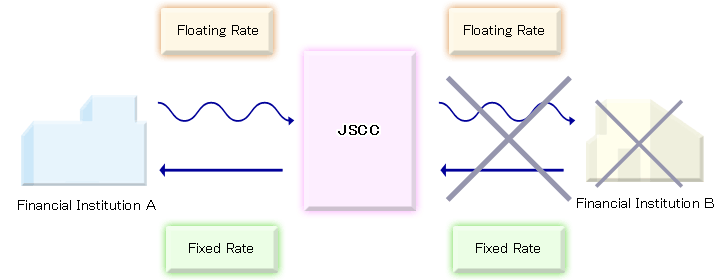

Figure 12.6 Fixed payer failure mitigated by CCP (Source: https://www.jpx.co.jp/jscc/en/cash/irs/clearing.html)

The largest CCPs are [LCH (formerly London ClearingHouse)](https://www.lch.com/services/swapclear), about $89\%$ of the market in USD; and [CME (a combination of the former Chicago Mercantile Exchange and the former Chicago Board of Trade)](https://www.cmegroup.com/trading/interest-rates/cleared-otc.html), about $11\%$ in USD. These two also dominate other currencies, with [Eurex](https://www.eurexclearing.com/clearing-en/markets-services/eurex-otc-clear/interest-rate-swaps) and [JSCC](https://www.jpx.co.jp/jscc/en/otc/index.html) having smaller parts of EUR, JPY and other markets.

The size of the interest rate swap market is astonishing. Table 12.8 shows the sizes of major world markets and economies.

Table 12.8 | Market Sizes &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;|
------------- | ----------------------- |

| Statistic | Size (US&dollar;Trillions) | As/of Date |
|----|:----:|:----:|
| Interest rate swaps | $\$466$ Notional<br>$\$11.3$ Net | December 2020$^a$ |
| Interest rate options | $\$37$ Notional<br>$\$0.9$ Net | December 2020$^a$ |
| F/X forwards | $\$98$ Notional<br>$\$3.2$ Net | December 2020$^a$ |
| Credit default swaps | $\$8.4$ Notional<br>$\$.202$ Net | December 2020$^b$ |
| Market Value of all listed stocks (world) | $\$95.2$ | December 2020$^c$ |
| Market Value of all bonds (world) | $\$123$ | December 2020$^d$ |
| Gross domestic product (world) | $\$93.86$ | December 2020$^e$ |
| Total household wealth (world) | $\$418.3$ | December 2020$^f$ |
| US residential mortgage-backed securities | $\$11.214$ | December 2020$^g$ |
| US residential mortgages (incl HE) | $\$10.04$ | December 2020$^h$ |
| Value of US housing | $\$36.2$ | December 2020$^i$ |

Sources: a=[Bank for International Settlements 1](https://stats.bis.org/statx/srs/table/d5.1?f=pdf); b=[Bank for International Settlements 2](https://stats.bis.org/statx/srs/table/d10.1?f=pdf);
c=[World Federation of Exchanges](https://focus.world-exchanges.org/issue/december-2020/dashboard); d=[SIFMA 1](https://www.sifma.org/resources/research/research-quarterly-fixed-income-issuance-and-trading-second-quarter-2021/); e=[International Monetary Fund](http://www.imf.org/external/datamapper/NGDPD@WEO/OEMDC/ADVEC/WEOWORLD); f=[Credit Suisse global wealth report](https://www.credit-suisse.com/corporate/en/research/research-institute/global-wealth-report.html); g=[SIFMA 2](https://www.sifma.org/resources/research/research-quarterly-fixed-income-outstanding-fourth-quarter-2020/); h=[New York Fed](https://www.newyorkfed.org/microeconomics/hhdc.html); i=[Zillow](https://www.zillow.com/research/us-total-housing-value-2020-28704/)

The notional amount of outstanding swaps is more than all the wealth in the world. The notional amount is a multiplier that does not actually change hands; it is used to determine the flows back and forth between fixed payer and fixed receiver. So the actual movements of cash are about two orders of magnitude less than the notional even before the fixed-floating offset. The net amount, essentially the sum of the values of seasoned swap as in \eqref{eq:seasoned_rcvr_swap}, is much less. But it's still a formidable figure.

One of the reasons the interest rate swap market is so large is the previously mentioned use of swaps by banks for asset-liability management. Consider the bank in our example at the beginning of Section 12.2.4: short-term rates were $1\%$ and long-term rates were $2\%$. The bank made a 20-year loan at $3.5\%$. If short-term rates rose to $4\%$, the loan would be unprofitable.

To hedge away this risk, the bank could enter into a 20-year payer swap for the same notional as the loan. The swap rate $SW(20)$ would likely be close to long-term rates of $2\%$; say $SW(20)=2.25\%$. The floating payments the bank receives as part of the swap offset the payments it owes to its short-term depositors, while the swap's fixed payments subtract from the fixed payments the bank is receiving from the loan, locking in a $1.25\%$ spread with virtually no risk.

The only thing left unhedged in our simple example is the final repayment of capital on the loan, which can be handled by a zero coupon swap. In fact the bank will simply look at everything going out or coming in for the next 30 years or so, and make sure it has hedged the asset-liability mismatch.

The other side of this hedge is often taken by pension plans (called superannuation schemes in UK usage). Such plans set aside funds to provide for workers after retirement; they typically have very long horizons as some members of the current workforce will not retire for decades.

Like banks, these plans have a maturity mismatch, but it's the opposite of the bank mismatch. Pension plans have long-term liabilities and short-term assets. They therefore often engage in [liability-driven investment ("LDI")](https://blogs.cfainstitute.org/investor/2017/11/21/beyond-modern-portfolio-theory-liability-driven-investment-strategies/), which is just the mirror image of the asset-liability management practiced by banks.

This is fortunate as it creates a natural offset. The individuals borrowing from banks are interested in building businesses, getting educations, and buying houses for family formation. All of these activities need capital now for long-term payoffs. The workers covered by pension plans are setting aside capital now to pay for their retirement in the long term, so they are interested in long-term payoffs. It's a beautiful match, intermediated by banks, pension plans, and other financial institutions. Interest rate swaps &mdash; as Table 12.8 shows &mdash; are a huge part of this horizon transfer process.

### 12.2.7 Longevity risk ###

We noted in the previous section that there is a natural offset between banks and pension plans. But the offset relies on the pension plan's knowledge of what its obligations are going to be, and that knowledge requires accurate demographic lifespan projections. The uncertainty around these projections is called **`mortality risk`** when lifespans are shorter than expected, and **`longevity risk`** when lifespans are longer than expected. Current economic concerns are focused on longevity risk.

If populations simply scale up their productivity as they live longer &mdash; say a population living to be $90$ becomes $9/8$ as productive as they were when they were living to be $80$ &mdash; then there won't be a mismatch between resources and demand for resources. Recognizing this, [Denmark's pension system](https://www.ssa.gov/policy/docs/progdesc/ssptw/2016-2017/europe/denmark.html) has a program of raising retirement age and encouraging pension deferral with a formula based on national longevity. Other countries have not been as explicit but have moved to increase retirement age.

But in many areas, the extra years of a longer life are simply tacked on to retirement years without changing productive years. That causes a concomitant lowering in the ratio of resource production to resource use. The most obvious implication of that lower ratio is to disadvantage public and private pension plans that promise to pay a regular amount for the remaining life of a retiree ("defined benefit" plans). They will need more money if people extend their retirement period. It's no coincidence that [Stanford University's Center on Longevity](http://longevity.stanford.edu/about/) has nine [corporate affiliates (donors)](http://longevity.stanford.edu/scl-corporate-affiliates-program/), eight of which are financial companies. The ninth is the [American Association of Retired Persons](https://www.aarp.org/), which markets medical insurance to older people.

Medical insurance companies may need to pay out more if people live longer. Insurance companies paying [annuities](https://www.iii.org/article/the-difference-between-annuities-and-life-insurance) (fixed payments for the life of an individual) are another form of pension plan and are also exposed to longevity risk.

Beneficiaries of increased longevity include companies that are paid to provide care to the elderly like nursing home operators, pharmaceutical companies, and medical equipment producers. Life insurance companies will be able to postpone payments if people live longer, which is why insurance companies often diversify by offering both annuities and life insurance with opposite exposures to increasing longevity.

There have been attempts to create longevity swap markets, where one side might pay a fixed rate and the other side would receive the current average life span in a country. Recently life expectancy at birth in the US was [78.6 years](https://www.cdc.gov/nchs/fastats/life-expectancy.htm). A longevity swap established now might have the payer receiving a fixed $\$78.6$ and paying whatever the latest life expectancy figure is each year. So of life expectancy is $79.6$ years, the longevity payer loses $\$1$; if life expectancy is $\$77.6$, the longevity payer gains $\$1$.

With such a swap, a defined benefit pension plan could be a longevity receiver, exchanging payments with a nursing home operator who was a longevity payer. The nursing home operator would look at the longevity payments as franchise preservation hedging, while the pension plan would be able to invest less in stocks and bonds because it wouldn't have to anticipate worst case longevity.

Despite the massive amount of world productive resources that is subject to longevity risk, there is no active capital market in longevity swaps. The imbalance between the size of natural longevity receivers (very large) and natural longevity payers (not so large) is more of a societal problem than a problem that can be fixed by a clever capital markets solution.

Some insurance companies offer insurance policies against longevity risk, as explained by the trade group [Institutional Longevity Markets Association](http://www.lifemarketsassociation.org/about_guiding_principles.html). These policies, generally called pension risk transfer insurance, offload longevity risk from a pension plan (which pays a fixed fee) to an insurance company (which guarantees lifetime payments to retirees). However the capacity for such policies is not large enough to cure a demographic imbalance across an entire country.

## 12.3 Illiquidity hedging ###

[The GARP Buy Side Risk Managers Forum](https://www.garp.org/media/a1Z1W000003lyWQUAY) defines **`asset and market liquidity`** as
>The degree to which a financial instrument can be converted to cash within a specified time horizon and at a specified cost.

If the act of buying or selling does not have much impact on the asset's price, then it is liquid; if there is a big impact, then the asset is illiquid. Liquidity is dependent on size and urgency. An asset may be liquid if only a small amount is being transacted, but illiquid in larger size. Similarly an asset may be illiquid if it needs to be transacted over the next minute, but liquid over the next year. Market conditions also play a role in liquidity: in some markets it may be easier to buy than sell or vice versa.

The third hedging category is **`illiquidity hedging`**. We've already seen a possible illiquidity problem in banks that can't meet short-term demands even if they have substantial long-term but illiquid investments or loans. Risks arising from yield curve reshaping can be hedged with interest rate swaps, but there is no hedge for the negative feedback loop caused once there are forced sales of illiquid assets.

We've seen that for banks, there is a mechanism of government support to help stop bank runs. But other investors don't enjoy this backing.

If a portfolio manager decides that conditions have changed for Apple Computer stock (AAPL), precipitating a decision to buy or sell, there will be no problem transacting. AAPL daily trading volume is routinely in the tens of billions of dollars, so the portfolio manager's trade is likely to be absorbed virtually instantly. With that much volume, the portfolio manager is likely to be a **`price taker`**, transacting with virtually no impact on AAPL's price.

But what if the portfolio manager owns (or wants to own) an office building and decides that conditions have changed and a transaction is desired? Commercial real estate typically has a time on market ("TOM") of $10-20$ months.[$^{12}$](#twelve_footnotes) During that time conditions may change radically. If the originator of the transaction wants to speed things up, the price will move in the wrong direction or the transaction just won't happen.

There is no perfect hedge for this kind of illiquidity. Liquid assets are generally fungible: there are large numbers of functionally identical versions of the asset, like a share of Apple Computer. Illiquid assets are generally idiosyncratic: no office building is exactly like any other office building.

However even illiquid assets have characteristics like location, square feet, amenities, and quality that are more systematic than idiosyncratic. These systematic characteristics can sometimes be mapped onto liquid instruments that might be used to mitigate some of the risk in the illiquid investment. For example, the [CMBX index](https://ihsmarkit.com/products/markit-cmbx.html) and its many sub-indices are based on a number of commercial mortgage-backed securities. Trading in credit default swaps based on this family of indices is liquid, so a portfolio manager can add or subtract commercial mortgage exposure easily. If commercial buildings are doing well (poorly), then commercial mortgages are probably also doing well (poorly).

However the hoped-for relationship between an actual set of commercial buildings and a traded index like CMBX may break down. This is another form of **`basis risk`**: the risk that the item being hedged is not fully matched with the hedge. The idiosyncratic properties of the commercial real estate being hedged may dominate its systematic properties, or the fact CMBX credit default swaps are based on mortgages and not property ownership may come into play. It is possible to have a wrong-way hedge &mdash; one in which the item being hedged goes down and the item doing the hedging goes up, which (since the hedge is short) is a lose-lose situation. Thus, like longevity risk, illiquidity risk is very hard to hedge successfully.

## 12.4 Distribution reshaping ##

The fourth kind of hedging seeks to reshape an outcome distribution. There are many techniques to reshape distributions, but none of them can produce a distribution that stochastically dominates the original distribution. However, reshaping can be done to produce an outcome distribution that has higher utility to an investor.

Selling (buying) **`futures`** is a simple way to decrease (increase) market exposure without selling (buying) individual securities and without committing a lot of capital. Properly done, futures transactions scale the volatility of a portfolio's outcome distribution up or down.

A future is similar to a forward purchase: one party agrees to buy and another party agrees to sell an asset $S$ at a price agreed on today, $T$ years from now. If $\text{fut}(S,T)$ is the agreed-on price, then the party who will be buying can borrow $\text{fut}(S,T)exp(-rT)$ today (at the $T$-year default-free rate $r$) in order to have the purchase price $T$ years from now. The selling party can just buy the underlying at the current price $S_0$ in order to have it for sale. Equating the two sides in the usual way gives
$$\text{fut}(S,T)=S_0exp\bigl(rT)\label{eq:future_rate}\tag{12.50}$$
This is equivalent to \eqref{eq:forward_rate}.

In practice, forwards are bilateral contracts while futures are traded on exchanges and require frequent exchanges of collateral. Exchange-traded instruments have extensive procedures to avoid counterparty default, so futures traders need to maintain cash in a margin account that can and will be seized if the trader defaults on its obligations. Adjustments might need to be made if the underlying asset pays dividends. If the underlying asset is physical &mdash; for example, if it's oil, a metal, or an agricultural commodity &mdash; adjustments might need to be made to reflect storage costs and spoilage. Thus a more precise version of \eqref{eq:future_rate} requires further adjustment to reflect these additional factors.

Very active futures markets exist for most developed country stock and government bond indicies, including:
- US: [Standard & Poors 500](https://www.cmegroup.com/trading/equity-index/us-index/sandp-500.html); [US Treasury](https://www.cmegroup.com/trading/why-futures/welcome-to-us-treasury-futures.html)
- UK: [FTSE](https://www.theice.com/products/38716764/FTSE-100-Index-Future); [Gilts](https://www.theice.com/interest-rates/gilt-futures-and-options)
- Germany: [DAX](https://www.eurexchange.com/exchange-en/products/idx/dax); [Bunds, Bobls, and Schatzes](https://www.eurexchange.com/exchange-en/products/int/fix)
- Japan: [Nikkei 225](https://www.jpx.co.jp/english/derivatives/products/domestic/225futures/01.html); [JGB](https://www.jpx.co.jp/english/derivatives/products/jgb/jgb-futures/01.html)

Selling appropriate futures against a long-only portfolio can lower variance by lowering exposure to a close substitute for its first principal component, like the overall stock or bond market. Similarly buying futures can scale up variance. Finer tuning with other futures transactions can add or remove other systematic exposures and their associated volatilities, like style tilts in equity or key rate exposures in fixed income. Basis risk is always a concern, though: care must be taken to see that the original assets really do respond to the systematic factors being hedged.

### 12.4.1 Distribution reshaping with options ###

Hedging techniques using European put and call options can surgically reshape outcome distributions, since strike prices can be set in a way that cuts and pastes segments of distributions.

Perhaps the simplest example of a static technique is the purchase of a European put option maturing at time $T$ on an underlying asset with a lognormal outcome distribution. That snips out the lower tail of the time-$T$ distribution, but moves the rest of the cdf left as shown in Figure 12.8b. Figure 12.8a shows the payoff pattern at time $T$ of the underlying vs. the underlying plus the put.

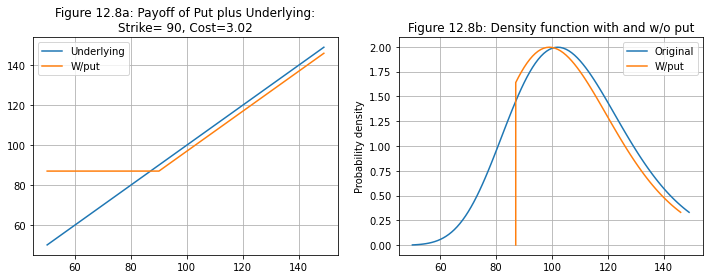

In [15]:
#Show put buying

#Graphing code used in all subsequent distribution shaping figures
def dual_dist_hedge_graph(x,y,y_norm,leg_trade,title1,title2):
    plt.figure(figsize=(12,4))
    #Payoff graph
    plt.subplot(1,2,1)
    plt.plot(x,x,label='Underlying')
    plt.plot(x,y,label=leg_trade)
    plt.grid()
    plt.legend()
    plt.title(title1)
    #Distribution graph
    plt.subplot(1,2,2)
    plt.ylabel("Probability density")
    plt.plot(x,y_norm,label='Original')
    plt.plot(y,y_norm,label=leg_trade)
    plt.grid()
    plt.legend()
    plt.title(title2)
    
    plt.show()

#Front ends for quanto_call and quanto_put routines above
#Simplifies them to Black-Scholes (same as formula 9.3)
def black_scholes_call(X,K,T,r,sigma):
    return(quanto_call(X,T,r,r,K,sigma,0.,1.))
def black_scholes_put(X,K,T,r,sigma):
    return(quanto_put(X,T,r,r,K,sigma,0.,1.))
    
#Common parameters used in all subsequent distribution shaping figures
money=100
time=1
rfree=.02
sigma=.2
x=np.arange(50.,150.,1.)
y_norm=spst.norm.pdf(np.log(x),np.log(money)+rfree*time,sigma)

#Buy-put trade
put_strike=90
put_cost=black_scholes_put(money,put_strike,time,rfree,sigma)

under_with_trade=[max(put_strike-put_cost,u-put_cost) for u in x]
title_1="Figure 12.8a: Payoff of Put plus Underlying:\nStrike=%3.f" % put_strike
title_1+=", Cost=%2.2f" % put_cost
title_2="Figure 12.8b: Density function with and w/o put"
legend="W/put"

dual_dist_hedge_graph(x,under_with_trade,y_norm,legend,title_1,title_2)

The blue lines show the underlying's time-$T$ payoff pattern (left graph) and lognormal distribution (right graph). $T=1$ in these examples. The time-$0$ price of the underlying ("the money") is $100$, and the center of the time-$T$ distribution is $100exp(rT)$.

The left orange line shows the payoff pattern of the underlying plus a put option struck at $90$ when the put option matures at time $T$; the right orange line shows the pdf (density function) of the underlying+put at time $T$.

The underlying-plus-put pdf has no probability of any outcome below $90$ minus the cost of the put, i.e. disastrous outcomes are avoided. The rest of the distribution is shifted left to pay for the option. Which shape &mdash; the blue or the orange &mdash; is better is a matter of risk preference.

If an investor thinks that the cost of buying a put option is too low because the market's expectation of the future distribution is just wrong, then the investor might buy a put option to express a directional view rather than, or in addition to, a risk preference.

For the remainder of this section, we'll show a number of other static option techniques that are commonly used to reshape distributions. Traders have given some of them colorful names, and they are only a sample of a vast arsenal.

Figures 12.9a and 12.9b show what happens when a call struck at $110$ is written (sold).

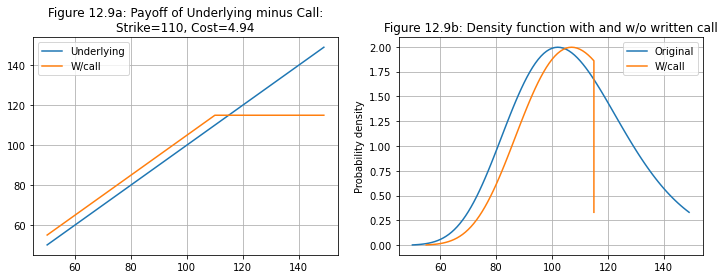

In [16]:
#Show selling call

call_strike=110
call_cost=black_scholes_call(money,call_strike,time,rfree,sigma)

under_with_trade=[min(call_strike+call_cost,u+call_cost) for u in x]
title_1="Figure 12.9a: Payoff of Underlying minus Call:\nStrike=%3.f" % call_strike
title_1+=", Cost=%2.2f" % call_cost
title_2="Figure 12.9b: Density function with and w/o written call"
legend="W/call"

dual_dist_hedge_graph(x,under_with_trade,y_norm,legend,title_1,title_2)

Writing a call is in a way the mirror image of buying a put. The written call gives away the upper end of the outcome distribution and redistributes it across the rest of the distribution by profiting from the call premium as shown above.

A **`put spread`** provides limited downside protection as shown in Figures 12.10a and 12.10b.

A put is bought down from the money while another put is written even further down from the money. We used $90$ for the bought put strike and $80$ for the written put strike. Above the higher strike put, nothing happens except for the loss of the put cost. But the cost is lower than just buying a put because money was gained by writing the lower strike put. The net is still negative, but not as negative as just buying a put.

Also there will probably be a benefit from volatility skew as the lower-struck put probably has a higher implied volatility than the higher-struck put as shown in Figure 8.5. Between the two strikes, the higher-struck put provides downside protection. Below the lower strike, the downside protection is capped at the difference between the two strikes, minus the cost.

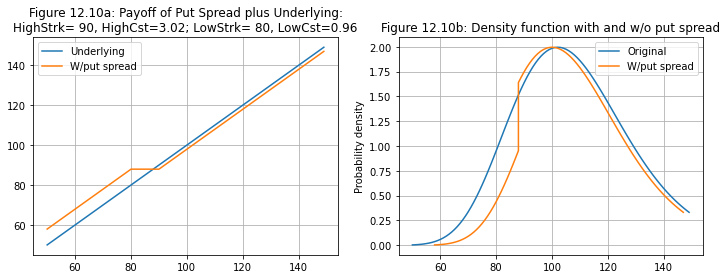

In [17]:
#Show put spread

low_put_strike=80
high_put_strike=90
low_put_cost=black_scholes_put(money,low_put_strike,time,rfree,sigma)
high_put_cost=black_scholes_put(money,high_put_strike,time,rfree,sigma)

under_with_trade=np.concatenate(( \
    [u+high_put_strike-low_put_strike for u in x if u<=low_put_strike], \
    [high_put_strike for u in x if low_put_strike<u<high_put_strike], \
    [u for u in x if u>=high_put_strike]))
under_with_trade-=(high_put_cost-low_put_cost)

title_1="Figure 12.10a: Payoff of Put Spread plus Underlying:\nHighStrk=%3.f" \
    % high_put_strike
title_1+=", HighCst=%2.2f" % high_put_cost
title_1+="; LowStrk=%3.f" % low_put_strike
title_1+=", LowCst=%2.2f" %low_put_cost
title_2="Figure 12.10b: Density function with and w/o put spread"
legend="W/put spread"

dual_dist_hedge_graph(x,under_with_trade,y_norm,legend,title_1,title_2)

A **`call spread`** sells off upside participation as shown in Figures 12.11ab.

Like a put spread, one option is bought and one is sold. In this case a call option up from the money is sold, and another call even further up from the money is bought. As with the put spread, volatility skew may work in favor of such a trade.  (A volatility smile may work against the trade.) The payoff pattern looks like a cheap call until the higher call kicks in, at which point the contribution is capped.

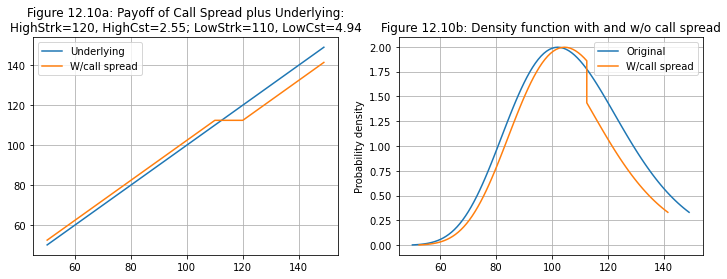

In [18]:
#Show (bear) call spread

low_call_strike=110
high_call_strike=120
low_call_cost=black_scholes_call(money,low_call_strike,time,rfree,sigma)
high_call_cost=black_scholes_call(money,high_call_strike,time,rfree,sigma)

under_with_trade=np.concatenate(( \
    [u for u in x if u<=low_call_strike], \
    [low_call_strike for u in x if low_call_strike<u<high_call_strike], \
    [u+low_call_strike-high_call_strike for u in x if u>=high_call_strike]))
under_with_trade+=(low_call_cost-high_call_cost)

title_1="Figure 12.10a: Payoff of Call Spread plus Underlying:\nHighStrk=%3.f" \
    % high_call_strike
title_1+=", HighCst=%2.2f" % high_call_cost
title_1+="; LowStrk=%3.f" % low_call_strike
title_1+=", LowCst=%2.2f" %low_call_cost
title_2="Figure 12.10b: Density function with and w/o call spread"
legend="W/call spread"

dual_dist_hedge_graph(x,under_with_trade,y_norm,legend,title_1,title_2)

Figures 12.12ab show a **'straddle'**, which is a way to bet on large moves. We've already seen this trade in Figure 8.3: both a put and a call are purchased at the money. If the underlying stays at the money, the straddle purchaser loses the put and call premia. But as the underlying moves away from the money, either the put (on a down move) or the call (on an up move) starts becoming more valuable. If the underlying moves far enough, then the put value (down) or call value (up) will become big enough to pay for the combined premia, plus a profit.

Together with the underlying, a straddle caps the loss on the downside and enhances the win on the upside. Thus a bought straddle anticipates more probability in the tails of the underlying distribution than was priced into options, while a sold straddle anticipates more probability in the center of the distribution than was priced in.

A straddle is a type of **`gamma`** trade. Gamma, explained more fully in Section 12.4.2, is the Greek letter that denotes the second derivative of changes in the price of an option with respect to changes in the price of the underlying: it is essentially the same as convexity, which we studied in Chapter 3. Bought options have positive gamma, i.e. positive convexity, and they like big moves.

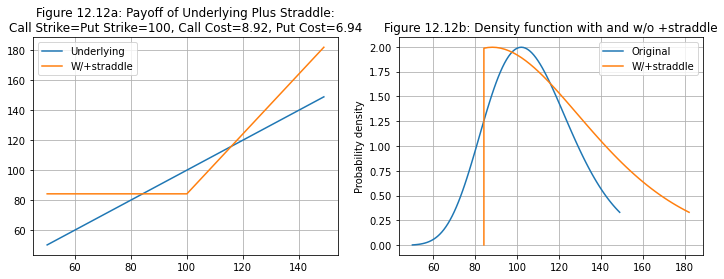

In [19]:
#Show a long straddle

call_cost=black_scholes_call(money,money,time,rfree,sigma)
put_cost=black_scholes_put(money,money,time,rfree,sigma)

under_with_trade=np.concatenate(\
    ([money-call_cost-put_cost for u in x if u<=money], \
    [u+(u-money)-call_cost-put_cost for u in x if u>money]))

title_1="Figure 12.12a: Payoff of Underlying Plus Straddle:"+ \
    "\nCall Strike=Put Strike=%3.f" % money
title_1+=", Call Cost=%2.2f" % call_cost
title_1+=", Put Cost=%2.2f" % put_cost
title_2="Figure 12.12b: Density function with and w/o +straddle"
legend="W/+straddle"

dual_dist_hedge_graph(x,under_with_trade,y_norm,legend,title_1,title_2)

A **`short straddle`** sells both a put and a call at the money; this trade enhances the center of the distribution at the expense of the tails, as shown in Figures 12.13ab.

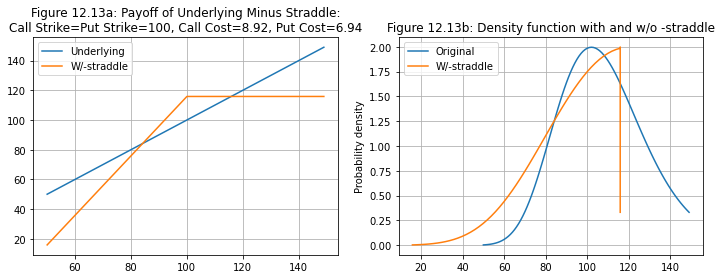

In [20]:
#Show a short straddle

under_with_trade=np.concatenate(\
    ([u+(u-money)+call_cost+put_cost for u in x if u<=money], \
    [money+call_cost+put_cost for u in x if u>money]))

title_1="Figure 12.13a: Payoff of Underlying Minus Straddle:"+ \
    "\nCall Strike=Put Strike=%3.f" % money
title_1+=", Call Cost=%2.2f" % call_cost
title_1+=", Put Cost=%2.2f" % put_cost
title_2="Figure 12.13b: Density function with and w/o -straddle"
legend="W/-straddle"

dual_dist_hedge_graph(x,under_with_trade,y_norm,legend,title_1,title_2)

A **`strangle`** (sometimes called a **`short strangle`**) is similar to a short straddle, but with a little different payoff pattern.

As shown in Figures 12.14ab, a strangle brackets the money by writing a put struck down from the money and writing a call struck up from the money. The owner of a strangle benefits if the price doesn't move outside the bracket. The further outside the bracket the price moves, the worse things get. A strangle therefore has virtually unlimited liability: it trades the tails of the distribution for the center of the distribution. If the strikes are set reasonably far away from the money, a strangle works most of the time, but on a big move a lot of money can be lost.

Trades like strangles and short straddles are not-so-jokingly called "picking up dimes in front of a steamroller," since most of the time there is a small profit. However when there is a big move, it's like getting run over by a steamroller. That's especially true when only the options part of the trade is done; if options plus underlying are in place then the underlying provides some offset.

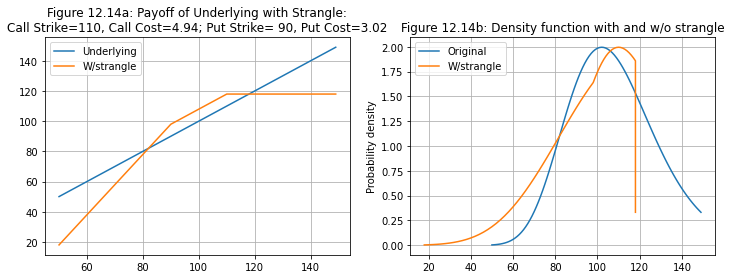

In [21]:
#Show a (short) strangle

put_strike=90
call_strike=110

put_cost=black_scholes_put(money,put_strike,time,rfree,sigma)
call_cost=black_scholes_call(money,call_strike,time,rfree,sigma)

under_with_trade=np.concatenate(\
    ([u+(u-put_strike) for u in x if u<=put_strike], \
     [u for u in x if put_strike<u<call_strike], \
     [call_strike for u in x if u>=call_strike]))
under_with_trade+=call_cost+put_cost

title_1="Figure 12.14a: Payoff of Underlying with Strangle:\nCall Strike=%3.f" \
    % call_strike
title_1+=", Call Cost=%2.2f" % call_cost
title_1+="; Put Strike=%3.f" % put_strike
title_1+=", Put Cost=%2.2f" % put_cost
title_2="Figure 12.14b: Density function with and w/o strangle"
legend="W/strangle"

dual_dist_hedge_graph(x,under_with_trade,y_norm,legend,title_1,title_2)

Options traders can wax lyrical, as evidenced by the **`butterfly spread`** shown in Figures 12.15ab.

The butterfly spread is a limited loss version of a strangle. A typical butterfly spread consists of call options at three different strikes: a call bought down from the money (say at strike $S_d$); two calls written at the money (at strike $S_0$), and another call bought up from the money (at strike $S_u$). Note that a butterfly spread is essentially a second difference if the strikes are evenly spaced; thus the Breeden-Litzenberger method described in Section 9.3.1 was a way to use the prices of butterfly spreads to retrieve underlying risk-neutral distributions.

If the underlying is outside the bracket $[S_d,S_u]$ at maturity, the trade contributes a constant negative amount (the cost of putting on the position) not dependent on the level of the underlying. Inside the bracket, the trade contributes an upside-down "V" peaking in the middle ($S_0$).

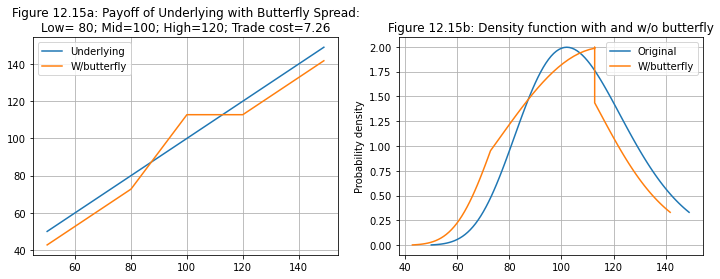

In [22]:
#Show payoff pattern of a butterfly spread

low_strike=80
mid_strike=100
high_strike=120

low_call_cost=black_scholes_call(money,low_strike,time,rfree,sigma)
mid_call_cost=black_scholes_call(money,mid_strike,time,rfree,sigma)
high_call_cost=black_scholes_call(money,high_strike,time,rfree,sigma)

under_with_trade=np.concatenate(\
    ([u for u in x if u<=low_strike], \
     [u+(u-low_strike) for u in x if low_strike<u<=mid_strike], \
     [u+ (high_strike-u)*(mid_strike-low_strike)/(high_strike-mid_strike) \
      for u in x if mid_strike<u<=high_strike], \
     [u for u in x if u>high_strike]))
trade_cost=low_call_cost-2*mid_call_cost+high_call_cost
under_with_trade-=trade_cost

title_1="Figure 12.15a: Payoff of Underlying with Butterfly Spread:\nLow=%3.f" \
    % low_strike
title_1+="; Mid=%3.f" % mid_strike
title_1+="; High=%3.f" % high_strike
title_1+="; Trade cost=%2.2f" % trade_cost
title_2="Figure 12.15b: Density function with and w/o butterfly"
legend="W/butterfly"

dual_dist_hedge_graph(x,under_with_trade,y_norm,legend,title_1,title_2)

A **`zero cost collar`** consists of buying a put down from the money (say at $90\%$) and writing a call up from the money where the strike is chosen so that the written call exactly offsets the cost of the put. The collar sells off the tails – no big drops, no big gains. If there is volatility skew, the strike on the upside is closer to the money than it would be if the underlying were lognormal.

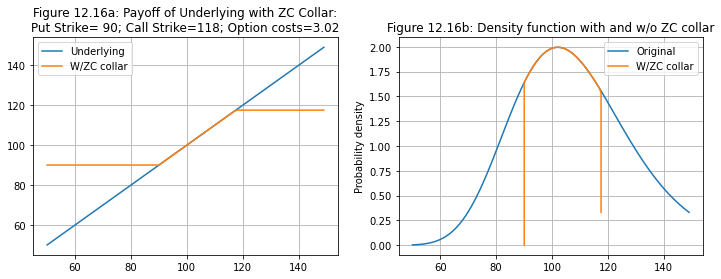

In [23]:
#Show payoff pattern of a zero cost collar

put_strike=90
call_strike=117.50468   #just did trial and error to find strike that matches prices

put_cost=black_scholes_put(money,put_strike,time,rfree,sigma)
call_cost=black_scholes_call(money,call_strike,time,rfree,sigma)

under_with_trade=np.concatenate(\
    ([put_strike for u in x if u<=put_strike], \
     [u for u in x if put_strike<u<=call_strike], \
     [call_strike for u in x if call_strike<u]))

title_1="Figure 12.16a: Payoff of Underlying with ZC Collar:\nPut Strike=%3.f" \
    % put_strike
title_1+="; Call Strike=%3.f" % call_strike
title_1+="; Option costs=%2.2f" % put_cost
title_2="Figure 12.16b: Density function with and w/o ZC collar"
legend="W/ZC collar"

dual_dist_hedge_graph(x,under_with_trade,y_norm,legend,title_1,title_2)

There are infinite combinations of options, so infinite new shapes of distributions can be crafted. If the options are fairly valued, the payoff pattern will always have some losses and some wins, and will have zero expected value in the risk-neutral probability measure. More complicated strategies can be designed by putting together portfolios of options with varying times to maturity, and even more complicated strategies can be designed by dynamically trading options rather than just buying them and waiting for them to expire.

### 12.4.2 Option Greeks ###

There are five basic parameters in the Black-Scholes formula \eqref{eq:black_scholes_for_quanto}. Partial derivatives of the call and put formulas show how option prices will react to small changes in these parameters. As we noted in Chapter 9 (Footnote 3), these derivatives are called **`option Greeks`** because they are usually (but not always) denoted by Greek letters. Option Greeks are used to establish hedging positions that are first-order (and sometimes second-order) neutral, or that have desired tilts.

Table 12.9 summarizes the more common derivatives. The notation is from \eqref{eq:black_scholes_for_quanto}.

Table 12.9 | Option Greeks &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;|
------------- | ----------------------- |

| Name | Derivative wrt | &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Call | &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Put |
|----|:----:|----:|----:|
| Delta $\delta$ | Underlying Price $X_0$ | $N(d_1)$ | $N(d_1)-1$ |
| Gamma $\Gamma$ | Delta $\delta$ | $\frac{1}{X_0\sigma_X\sqrt{T}}\bigl(\frac{exp\bigl(\frac{-d_1^2}{2}\bigr)}{\sqrt{2\pi}}\bigr)$ | same |
| Vega/Kappa $\kappa$ | Volatility $\sigma_X$ | $X_0\sqrt{T}\bigl(\frac{exp\bigl(\frac{-d_1^2}{2}\bigr)}{\sqrt{2\pi}}\bigr)=\bigl(TX_0^2\sigma_X\bigr)\Gamma$ | same |
| Rho $\rho$ | Rate $r_f$ | $K_fTexp(-r_fT)N(d_2)$ | $\rho_{Call}-K_fTexp(-r_fT)$ |
| Theta $\theta$ | Time ($T$) | $\frac{1}{2}\bigl(X_0\sigma_X\bigr)^2\Gamma+\frac{r_f}{T}\rho_{Call}$ | $\theta_{Call}-K_fr_fexp(-r_fT)$ |

Table 12.9 has one second-order and four first-order derivatives. Since each option has a different set of Greeks, a portfolio with the desired Greeks can be formed with five reasonably different options by solving five equations in the five unknowns (weights of the options in the portfolio). For example, an options portfolio that has vega exposure and nothing else could be formed. That portfolio of options will give pure exposure to changes in volatility.

Since time and the price of the underlying are two of the key variables, the linear combination of five options that exhibits the desired exposure at a given point in time might not be the linear combination that exhibits the key exposures tomorrow. Thus some cleverness is required to come up with a set of options that gives the desired exposures but that doesn't require too much adjustment, especially procyclical adjustment. A portfolio manager would rather not be selling calls or buying puts because the market moved down, nor would the manager want to be buying calls or selling puts because the market moved up. In the next section, we'll show the method that is used by the [CBOE](https://www.cboe.com/) to compute the [VIX&reg; index](https://www.cboe.com/micro/vix/vixwhite.pdf) of volatility from a portfolio of options without adjustment.

The code segment shows an example where $\sigma_X=.2$, $r_f=2\%$, $X_0=K_f=100$, and $T=.25$.

In [24]:
#Simple delta example

def greeks(price,strike,r,time,sigma):
    #return a 6-vector of Black-Scholes Greeks:
    #BS price, delta, gamma, theta, vega, rho
    if price<=0 or strike<=0 or time<=0:
        return(6*[0])
    #Black-Scholes price
    d1=(np.log(price/strike)+(r+sigma**2/2)*time)/(sigma*np.sqrt(time))
    d2=d1-sigma*np.sqrt(time)
    n_of_d1=spst.norm.cdf(d1)
    n_of_d2=spst.norm.cdf(d2)
    bs_call=price*n_of_d1-np.exp(-r*time)*strike*n_of_d2
    #Greeks
    delta=n_of_d1
    gamma=np.exp(-d1**2/2)/(price*sigma*np.sqrt(2*np.pi*time))
    vega=time*gamma*sigma*(price**2)
    rho=strike*n_of_d2*time*np.exp(-r*time)
    theta=.5*((price*sigma)**2)*gamma+r*rho/time
    gr_vec=[bs_call,delta,gamma,theta,vega,rho]
    return(gr_vec)

sigma=.2
rf=.02
X0=K=100
T=.25

Orig_price,delta,gamma,theta,vega,rho=greeks(X0,K,rf,T,sigma)

X0_new=100.1
New_price,new_d,new_g,new_t,new_v,new_r=greeks(X0_new,K,rf,T,sigma)
diff_delta=(New_price-Orig_price)/(X0_new-X0)

print("     Original X0: %.2f" % X0)
print("  Original Price: %.4f" % Orig_price)
print("           Delta: %.4f" % delta)
print("\n          New X0: %.2f" % X0_new)
print("       New Price: %.4f" % New_price)
print("Difference delta: %.4f" % diff_delta)

     Original X0: 100.00
  Original Price: 4.2322
           Delta: 0.5398

          New X0: 100.10
       New Price: 4.2863
Difference delta: 0.5418


The finite difference delta from a small change in price is close to, but not the same as, the instantaneous delta from Table 12.9.

Options are usually wasting assets, since as time passes the option owner's power wanes until it disappears entirely at expiration. Thus the derivative of option price with respect to time is usually positive: longer-maturity options have higher prices. There are a few exceptions, but most of the time options lose value as they get closer to maturity. The worst time decay is at the strike price. 

Using the parameters in the previous example, but varying the strike price, produces Figure 12.20:

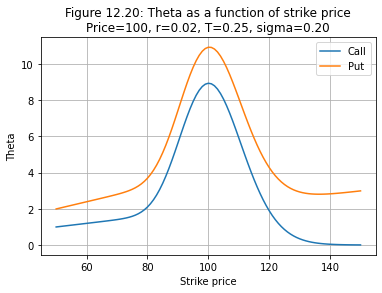

ATM call theta 8.93406342873292
ATM put theta 10.924088387118283


In [25]:
#Graph theta from previous example as a function of strike

strikes=np.arange(50,151,1)

plt.plot(strikes,[greeks(X0,k,rf,T,sigma)[3] \
                 for k in strikes],label="Call")
plt.plot(strikes,[greeks(X0,k,rf,T,sigma)[3]+rf*k*np.exp(-rf*T) \
                 for k in strikes],label="Put")
plt.xlabel("Strike price")
plt.ylabel("Theta")
plt.legend()
plt.grid()
str_title="Figure 12.20: Theta as a function of strike price\n"
str_title+="Price=%3.f" % X0
str_title+=", r=%3.2f" % rf
str_title+=", T=%3.2f" % T
str_title+=", sigma=%3.2f" % sigma
plt.title(str_title)
plt.show();

print("ATM call theta",greeks(X0,X0,rf,T,sigma)[3])
print("ATM put theta",greeks(X0,X0,rf,T,sigma)[3]+rf*X0*np.exp(-rf*T))

Here the at-the-money ("ATM") call (strike price $100$) is losing value at about $8.93$/year; the put is losing value at about $10.92$/year. The maximum theta strikes are a little higher than ATM.

The benefit gained from buying options (whether puts or calls) requires constant infusions of money, just like an insurance policy requires that its premiums be paid on an ongoing basis. This is reflected in positive theta, sometimes called "theta bleed" or "theta decay." Negative theta positions are usually similar to selling insurance: as we noted with strangles and short straddles, they are "dimes in front of steamroller" trades that usually make money but that can result in spectacular losses when they don't.  

Gamma is the second derivative with respect to the price of the underlying: it adjusts for responses to large moves. It peaks when the option is at the money, as shown in Figure 12.21. So does vega, the response to changes in volatility. The ratio of vega to gamma is $X_0^2\cdot T\cdot \sigma$; since $X_0$ and $\sigma$ are common properties of the underlying, the only way to differentiate between vega and gamma is to use options with different expiration times $T$.

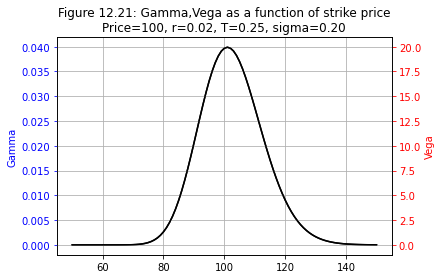

ATM delta 0.539827837277029
ATM gamma  0.039695254747701185
ATM vega  19.847627373850596
Vega/gamma ratio  500.0


In [26]:
#Gamma and vega

fig=plt.figure() # Create matplotlib figure

#Set up two axes because of different orders of
#magnitude between gamma and vega
ax = fig.add_subplot(111)
ax2 = ax.twinx() # Create another axis that shares the same x-axis as ax.

ax.plot(strikes,[greeks(X0,k,rf,T,sigma)[2] \
                 for k in strikes], \
                 color='black')
ax2.plot(strikes,[greeks(X0,k,rf,T,sigma)[4] \
                 for k in strikes], label="Vega", \
                 color='black')

ax.set_ylabel('Gamma', color='blue')
ax.yaxis.label.set_color('blue')
ax.tick_params(axis='y', colors='blue')

ax2.set_ylabel('Vega', color='red')
ax2.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='red')

#plt.xlabel("Strike price")
ax.grid(axis="x")
plt.grid()

str_title="Figure 12.21: Gamma,Vega as a function of strike price\n"
str_title+="Price=%3.f" % X0
str_title+=", r=%3.2f" % rf
str_title+=", T=%3.2f" % T
str_title+=", sigma=%3.2f" % sigma
plt.title(str_title)
plt.show();

print("ATM delta",greeks(X0,X0,rf,T,sigma)[1])
print("ATM gamma ",greeks(X0,X0,rf,T,sigma)[2])
print("ATM vega ",greeks(X0,X0,rf,T,sigma)[4])
print("Vega/gamma ratio ",X0**2*T*sigma)

Since time $T=.25$ is constant in Figure 12.21, the vega/gamma ratio is constant at 500. Thus the shapes of the vega and gamma curves are exactly the same: the only difference is in scale with the gamma scale on the left and the vega scale on the right.

For our example, when price=strike=$100$, a one unit increase in price will increase the delta by about $\Gamma=.0397$, i.e. from the $.5398$ noted above to $.5795$. This provides the same kind of positive convexity that benefits bond prices. Similarly a one unit decrease in price will decrease delta to $.5001$, thereby cushioning the fall. Taking the derivative of $\Gamma$ in Table 12.9 with respect to strike price shows that $\Gamma$ is maximized when the strike price equals the current price times $exp((r_f+\sigma^2/2)T)$.

The ATM vega of about $19.8$ means that if standard deviation were to increase from the $20\%$ used in our example to $21\%$, the option price would go up by $19.8\cdot(.21-.20)=.198$. 

Trading desks at broker-dealers make money through a mix of risk taking and risk hedging. The Greeks are used to protect broker-dealer franchises, as follows:

A **`broker`** is a matchmaker who takes no principal risk. An options broker would find a client who wants to buy an option and a client who wants to sell the exact same option and get them together for a fee. If the transaction is "DvP," or **`delivery versus payment`**, the dealer just acts as the middleman and has no exposure to movements in the markets or in the creditworthiness of the clients.

Very few broker-dealers actually have such a pure transaction-based business. Most also act as **`dealers`** who maintain inventory and who take risks with their own capital to facilitate trades and for other reasons. Consider a situation in which a dealer has a client who wants to buy a [call option on Google (Alphabet)](https://www.nasdaq.com/market-activity/stocks/goog/option-chain). The particular option wanted by the client may not trade very heavily, so there may be no seller at the moment. However the dealer knows that the option trades every hour or so. So the dealer may temporarily take the other side of the trade, and an hour later when a seller shows up, the dealer can unwind.

Over the course of a day for a large dealer, there may be thousands of such transactions. At any given time there may be hundreds or thousands of options in the dealer's inventory awaiting disposition. Sometimes the dealer may decide to "sail close to shore" and hedge away most risks in the "book," the collection of positions. The Greeks &mdash; actually many more than we have shown, going into mixed partial second and third derivatives &mdash; are computed, and the dealer can enter into offsetting transactions in heavily traded options to neutralize the book. Or the dealer may decide to lean in a certain direction by tilting Greeks.

**`Delta hedging`** is comparatively easy, since the underlying has delta exposure but nothing else. So going long or short the underlying, perhaps through a futures transaction, can neutralize delta. In terms of overall dollar exposures, the most likely thing that would bankrupt a dealer would be a large move in the underlying when there is a material delta exposure, so most options dealers hedge away delta for franchise preservation. 

### 12.4.3 Fixed income options ###

In the fixed income market, commonly used derivatives are called **`caps, floors, and collars`**.

Caps are molecules composed of atomic units called **`caplets`**. A caplet pays the buyer if a benchmark interest rate (typically LIBOR) is above a strike price at a given date in the future. The payoff function for a caplet looks like
$$\text{notional}*max(0,index-strike)/\text{periodicity}$$
For example, suppose an investor owns a caplet with six-month LIBOR as the index (periodicity 2 per yer), struck at $1\%$, maturing a year from now, on $\$1$Mn notional. If the six-month LIBOR rate from six months from now to one year from now is an annual $2.5\%$, the caplet owner will receive $\$7,500$ from the caplet writer. Note that the six-month LIBOR rate used to determine the payoff on the caplet maturing one year from now was already known six months prior to the payoff.

A cap strings together caplets struck at the same level over time. For example, a five-year cap might have caplets maturing $.5, 1, 1.5, 2, \dots, $ and $5$ years from now and all struck at $1\%$ and all with $\$1$Mn notional. A cap can be synchronized with an interest rate swap, so that a portfolio consisting of a receiver swap and a cap limits the payments the fixed receiver (floating payer) has to make during the life of the swap/cap to be no more than the cap's strike price. Each of the cap's caplets covers one payment during the life of the swap/cap.

A floor is an analogous collect of **`floorlets`**; each floorlet pays its owner if interest rates go below its strike price with payoff function
$$\text{notional}*max(0,strike-index)/\text{periodicity}$$

A **`fixed income collar`** is the simultaneous purchase of a cap struck at $s_c$ and sale of a floor struck at $s_f$, with $s_c>s_f$, both with identical maturities, notionals, and periodicities. This protects against higher rates while selling off the benefit of lower rates.

The equivalent of put-call parity (8.1)\eqref{put_call_conversion} is established by the following two-position portfolio:
- A payer interest rate swap with fixed rate $s$;
- A maturity- and notional-matched flor struck at $s$; and

Suppose $index>s$ at some payment time. Then (per unit of notional) the owner of the swap receives $index-s$ from the swap; the floorlet at this time is worthless. In total the owner of the payer swap/floor combination receives $index-s$.

Suppose $index<s$ at some payment time. Then (per unit of notional) the owner of the swap receives $index-s$ from the swap (which is actually a negative, i.e. a payment to the swap counterparty); the floorlet at this time produces $s-index$. Together the two cancel so the owner of the combination receives $0$.

Thus the combination of a payer swap and a matched floor has the same payoff pattern as a cap.
$$Cap=PayerSwap+Floor\label{eq:fixed_parity}\tag{12.60}$$
as long as everything is matched in strike, maturity, periodicity, and notional. Equivalently,
$$ReceiverSwap=Floor-Cap\label{eq:fixed_parity_receiver}\tag{12.61}$$

### 12.5 Convexity Hedging ##

The fifth type of hedging is **`convexity hedging`**.[$^{13}$](#twelve_footnotes) There are some kinds of exposures that can change precipitously as conditions change. In that case, the very act of trading to try to hedge the exposure can exacerbate the situation. Instead, a hedge should be designed that will anticipate and mitigate possible large market moves. Epigrammatically: prepare, not repair. We'll use **`mortgage convexity hedging`** to illustrate this problem.

As Table 12.8 showed, the value of the US residential housing stock is huge: over $\$35$ trillion. About one third of that amount is mortgaged (borrowed). Table 12.8 further shows that the great majority of mortgages have been securitized: that is, they have been placed in pools that allow the originators (banks and other financial institutions) to diversify and offload their mortgage lending exposures. The US MBS market is larger than the [entire fixed income market of any other country in the world](https://stats.bis.org/statx/srs/table/c1?f=pdf) other than China and Japan.

Many of these pools have been created through three large government agencies: "Fannie Mae" (the [Federal National Morgage Association](https://www.fanniemae.com/portal/index.html)); "Freddie Mac" (the [Federal Home Loan Mortgage Corporation](http://www.freddiemac.com/)); and "Ginnie Mae" (the [Government National Mortgage Association](https://www.ginniemae.gov/pages/default.aspx)).

Mortgage loans are secured by a property and typically have long maturity dates: $15$ to $30$ years. The standard fixed-rate mortgage is attractive to borrowers as it typically entails a fixed monetary payment each month, making housing expenses more predictable and (since they are spread out over a long period) affordable. Each month's payment for a fixed-rate mortgage consists of interest on the remaining principal, plus some repayment of principal. As time passes, the proportion of the fixed monthly payment that is principal increases, and the proportion that is interest decreases.

Let $P$ is the principal amount borrowed in a mortgage, $n$ the number of months (e.g. $n=360$ for a $30$-year mortgage), and $r$ the annual mortgage rate. Then at the end of the first month the interest owed is $Pr_m$ where $r_m=r/12$. There is also some principal repayment $p_1$ in the first monthly payment. Since each payment is the same, it must be true that the first month's payment equals the second month's payment, so
$$Pr_m+p_1=(P-p_1)r_m+p_2$$
where $p_2$ is the principal repayment in the second month. Thus $p_2=(1+r_m)p_1$. Repeating this reasoning shows that $p_i=(1+r_m)^{i-1}p_1$ for any $i=1,\dots,n$. The entire principal $P$ must be repaid over $n$ months, so
$$P=\sum_{i=1}^n p_i = p_1\frac{(1+r_m)^n-1}{r_m}$$
Thus the $i^{th}$ month's principal payment is
$$p_i=(1+r_m)^{i-1}\frac{P r_m}{(1+r_m)^n-1}\label{eq:mortgage_princ_payment}\tag{12.63}$$
and the cumulative principal paid through month $i$ equals
$$P\left(\frac{(1+r_m)^{i}-1}{(1+r_m)^n-1}\right)$$
The constant monthly payment of both principal and interest equals
$$Pr_m\left(1+\frac{1}{(1+r_m)^n-1}\right)\label{eq:mortgage_const_payment}\tag{12.64}$$
For example a $360$-month mortgage on a principal amount of $\$300,000$ at an annual fixed rate of $4\%$ has a monthly payment of $\$1,432$.

If a borrower fails to make payments, eventually a mortgage lender can take possession of the mortgaged house and sell it to recover unpaid principal and interest. That allows lenders to charge lower rates for mortgages than they would for unsecured loans. However, quite often people move house before they have finished repaying their mortgage. The lender would lose security if it continued the loan arrangement all the way to its full term. Instead, lenders allow homeowners to prepay the remaining principal on their loans. This prepayment can occur at any time, not just when the homeowner is moving.

The option to prepay a fixed-rate mortgage is valuable and gives rise to prepayment risk on the part of the lender, as noted in Section 3.4. The fixed-rate mortgage lender has conceded something like an interest rate floor to the mortgage borrower, struck at the current mortgage rate. If interest rates drop, large numbers of mortgage borrowers will get a new loan at the new prevailing lower interest rate. They exercise their right to prepay the old loan with the proceeds of the new loan.

Some mortgages are ARMs (Adjustable-Rate Mortgages); that is, the borrower pays a floating interest rate that changes with a benchmark rate like [LIBOR](https://www.theice.com/iba/libor) or [SOFR](https://apps.newyorkfed.org/markets/autorates/SOFR). For example, a **`5/1 ARM`** is a mortgage with a fixed rate for the first five years, followed by an annual reset frequency where the rate for the next year is updated based on the current value of a reference rate, plus a spread. ARMs have much less negative convexity than fixed-rate mortgages. However, the vast majority of residential mortgages in the US ($97.6\%$ at the end of 2020[$^{14}]($twelve_footnotes)) are fixed-rate.

A wave of prepayments can wash over the MBS market as MBS holders are suddenly given large amounts of cash that they will need to reinvest at the lower rates that caused them to get the cash in the first place. That buying wave can force rates down still further. Given the vast size of the MBS market, this procyclical behavior can become a systemic problem. For example, on March 4, 2020 [CNBC reported](https://www.cnbc.com/2020/03/04/weekly-mortgage-refinances-spike-26percent-with-help-from-coronavirus.html) that weekly mortgage refinances had spiked $26\%$ as interest rates fell due to coronavirus fears.

On the flip side when interest rates rise, the durations of MBS extend, as fewer than normal people pay back their existing mortgages. Having duration extending when interest rates are going up is doubly bad for a MBS holder: i.e. it's negative convexity.

How can MBS holders hedge this problem? They could try to delta-hedge by adjusting durations as they change. As interest rates rose, duration would go up, so to adjust delta the MBS holder could enter into payer swaps or could sell US Treasury futures. Similarly as interest rates fell, duration would be going down, so the MBS holder could enter into receiver swaps or could buy US Treasury futures.

But in a market whose size is over $\$10$ trillion, the size of the swap or Treasury future trades required to make a dent in rapidly changing MBS durations would be ruinous. Even though swaps and Treasurys are themselves enormous markets, they would be moved procyclically by the volume of trading required to keep MBS durations in check. This effect has been mitigated by the US Federal Reserve's quantitative easing program: as of March 2021, the Fed was buying about $25\%$ of MBS production, which it does not hedge.[$^{15}$](twelve_footnotes) But the volume of MBS held by banks and investors who are prone to hedging is still enormous.

The savvy hedger would try to be in a position to avoid pouring fuel onto the fire. If you're short rate gamma (convexity), you can use an options position to buy rate gamma. Then the options position will automatically adjust your duration for you. In effect you would try to buy back the optionality that was given away to mortgagees.

The preferred market for rate gamma hedging is the **`swaptions market`**.[$^{16}$](twelve_footnotes) Table 12.8 shows that the notional and gross amounts of interest rate options (largely swaptions) are about one tenth of the notional and gross amounts of interest rate swaps. This is enough to handle the sudden flows that occur because of mortgage rate changes.

A European payer swaption gives the holder the right but not the obligation to enter into a payer swap. A swaption has an **`optionality period`**, the length of time for which the holder can exercise the right to enter into a swap; and a **`swap tenor`**, which is the length of time the optioned swap is active. Thus a swaption is described as an "$m\times n$" ("m by n" or "m into n") swaption, where m is the optionality period and n is the swap tenor. The swaption also has a strike price, which is the fixed annual rate $K$ that the fixed payer will owe (while receiving LIBOR) if the swaption is exercised and the swap is entered into. A European receiver swaption has the same parameters, but the optioned swap is a receiver swap.

To price a payer swaption, note that $m$ years from now, the swaption owner will look at the then-prevailing swap rate for $n$-year swaps; call that rate $S$. The swaption owner will compare $S$ to the swaption strike price $K$ to determine if $S>K$.
- If so, the swaption holder can exercise the swaption and get a payer swap, while simultaneously entering into a receiver swap. The LIBOR legs of the payer and receiver swaps cancel each other. If $p$ is the periodicity (number of times per year there are payments), then the fixed legs bring in (receiver) $S/p$ and pay out (payer) $K/p$, so the swaption holder benefits by $(S-K)/p>0$ in each payment period, per unit of notional.
- If not, the swaption isn't exercised.

Thus the payment received at time $m+\frac{i}{p}$ $(i=1,\dots,pn)$ is $max(0,S-K)/p$. This is the payoff on a forward-starting caplet, i.e. one which is exercised at time m based on the level of $S$ at the time, but whose payoff doesn't come until time $m+i/p$.

The value of such an caplet is given by a variant on Black-Scholes which is simply called the [Black model](https://doi.org/10.1016/0304-405X(76)90024-6). It's a modification of (8.3)\eqref{eq:black_scholes} that takes into account forward-starting instruments:
$$CL(F,K,T,r,\sigma)=exp(-rT)\bigl(FN(d_1)-KN(d_2)\bigr)\label{eq:black_model}\tag{12.65}$$
$$d_1=\frac{ln\bigl(\frac{F}{K}\bigr)+\frac{\sigma^2}{2}T}{\sigma\sqrt{T}}, d_2=d_1-\sigma\sqrt{T}$$
The Black formula for the corresponding floorlet is
$$FL(F,K,T,r,\sigma)=exp(-rT)\bigl(-FN(-d_1)+KN(-d_2)\bigr)\label{eq:black_model_floorlet}\tag{12.66}$$

Applied to forward-starting caplets and floorlets, the forward parameter $F$ becomes the forward-starting swap rate $SF(m,m+n)$ given by \eqref{eq:forward_inception_swap_rate}. The time parameter $T$ is the optionality period $m$. $\sigma$ is the volatility of swap rates and $r$ is an appropriate discount rate, which we'll take from the swap curve, although conventions may vary.

The payer swaption is a series of these forward-starting caplets. The decision to exercise is taken at the common expiration of the optionality period $m$ years from now, but the cash flows come at different times during the $n$-year life of the optioned swap and thus need to be discounted differently. Summing up the discounted values of the caplets gives:
$$PayerSwaption(m,n,K)=$$
$$\frac{(SF(m,m+n)N(d_1)-KN(d_2)\bigr)}{p}
\sum_{i=1}^{pn}exp\bigl(-s(0,m+\frac{i}{p})(m+\frac{i}{p})\bigr)
\label{eq:payer_swaption}\tag{12.67}$$
$$d_1=\frac{ln\bigl(\frac{SF(m,m+n)}{K}\bigr)+\frac{\sigma^2}{2}m}{\sigma\sqrt{m}}, d_2=d_1-\sigma\sqrt{m}$$

A receiver swaption is a series of forward-starting floorlets, so by analogous reasoning together with parity \eqref{eq:fixed_parity}, we can say
$$RcvrSwaption(m,n,K)=$$
$$\frac{(-SF(m,m+n)N(-d_1)+KN(-d_2)\bigr)}{p}
\sum_{i=1}^{pn}exp\bigl(-s(0,m+\frac{i}{p})(m+\frac{i}{p})\bigr)
\label{eq:receiver_swaption}\tag{12.68}$$
$d_1$ and $d_2$ are as in \eqref{eq:payer_swaption}

A simple form of mortgage convexity hedging can now been seen. Suppose a portfolio manager owns a mortgage-backed security with $11$ years of life left. The component mortgages are paying $4\%$ interest. The manager expects based on a [mortgage prepayment model](https://philadelphiafed.org/-/media/research-and-data/publications/working-papers/2019/wp19-39.pdf) that if $10$-year rates fall below $2.5\%$, $30\%$ of the mortgages will suddenly prepay.

To hedge this risk over the next year, the manager could buy a $1\times10$ receiver swaption struck at $4\%$ on $30\%$ of the principal. Suppose rates hit $2.5\%$ in one year and $30\%$ of the principal is repaid. The manager takes three actions:
- Invests the repaid principal in a fixed rate bond;
- Enters into a payer swap; and
- Exercises the swaption, getting a receiver swap at $4\%$.

The LIBOR legs of the two swaps cancel, leaving the manager with a stream of $4-2.5=1.5\%$ incoming payments. The fixed rate bond delivers $2.5\%$ or close to it, so all told the manager maintains a $4\%$ income stream even though mortgage rates dropped and many mortgages prepaid.

# Chapter 12 Footnotes
<a name="twelve_footnotes"></a>

$^1$ Most large multinational companies trade in multiple venues in multiple currencies. Tesla, Inc. is traded on the [Frankfurt Borse in euros](https://www.boerse-frankfurt.de/equity/tesla-inc), so this example is just for illustrative purposes.
<br>

$^2$ "Equivalent" is an overstrong word: there are minor differences between currency forwards and an exchange of zero-coupon default-free instruments due to the limits of arbitrage. But the two alternatives are very similar.
<br>

$^3$ In practice there may be departures from the simple bilateral transaction described here. The forward may be cash settled: instead of the parties exchanging the two currencies, the losing party may just pay the winning party in one of the currencies, usually the more heavily traded currency. There may also be a central counterparty as described in Section 12.2.6.

$^4$ Despite the fact that we are working through an example where the euro currency is involved, the only currency referenced by this option is the dollar. The word "European" here refers to the style of the option and means &mdash; as noted in Section 9.2.1 &mdash; that the option can only be exercised at maturity.
<br>

$^5$ Teng, Erhardt, and G&uuml;nther, "The pricing of Quanto options under dynamic correlations." *Journal of Computational and Applied Mathematics* 275 (2015), 304-310. https://www.sciencedirect.com/science/article/pii/S0377042714003367. We have adapted their formulas (16) and (17). As the title implies, the authors solve for time-varying correlation but we have simplified the formula so that correlation is fixed.
<br>

$^6$ France produces about [4.6 billion liters of wine per year](http://www.oiv.int/en/statistiques/?year=2016&countryCode=FRA). It imports about [6.2 million liters per year](https://www.fas.usda.gov/data/france-wine-annual-report-and-statistics) from the US. So Philippe's business is more of a thought experiment than a reality, but it's helpful to illustrate our points.
<br>

$^7$ I have borrowed the unlikely but amusing paradigm of a French importer of California wines from Mark Kritzman's excellent explanation of Siegel's Paradox in Kritzman 2000, *Puzzles of Finance*. John Wiley & Sons.
<br>

$^8$ Allayannis and Weston use Tobin's Q as the measure of firm value. This is the ratio of market value ($V_0$ in our notation) to replacement cost of assets; it can be thought of as an adjusted market-to-book value ratio. Replacement cost of assets is difficult to calculate; Allayanis and Weston use an accounting method where they infer the vintages and depreciation pattern of in-place gross fixed assets, and add in the book value of inventories and LIFO reserves.
<br>

$^9$ Asymmetric information refers to the idea that a company's managers may have information that external shareholders don't, so the ability of external shareholders to replicate managers' actions as contemplated by Modigliani and Miller may not exist.
<br>

$^{10}$ As we saw in Chapter 3 (footnote 3), LIBOR is being phased out as a benchmark in most jurisdictions. In the US, the planned replacement is [SOFR, the Secured Overnight Financing Rate](https://apps.newyorkfed.org/markets/autorates/sofr).
<br>

$^{11}$ In practice LIBOR-based swap payments are discounted using [overnight index swap ("OIS") rates](https://doi.org/10.1016/j.frl.2020.101430) and adding a spread similar to a credit spread. This will change as LIBOR is phased out.
<br>

$^{12}$ The $10-20$ month TOM range for US commercial properties is the result of data compiled by Eugene Page and Martin Nguyen from [Centre Urban Real Estate Partners](http://www.centre-urban.com/). The data was compiled in April 2020 from [Costar Group](https://www.costargroup.com/) and covers the period 2005 through March 2020.
<br>

$^{13}$ A good discussion of mortgage convexity hedging can be found in a white paper by the MBS Strategies group at Lehman Brothers: Modukuri, Reddy, et. al., "Mortgage Convexity Risk," June 30, 2003. Ironically Lehman Brothers declared bankruptcy in September 2008 largely because of misinvestment in MBS.
<br>

$^{14}$ ICE Mortgage Technology&trade; Origination Insights Report February 2021, page 5 (All Mortgages). https://static.elliemae.com/pdf/origination-insight-reports/ICE_OIR_FEB2021.pdf
<br>

$^{15}$ Tatevossian, Leon, "Can We Still Blame MBS Hedgers?," March 25, 2021 lecture at New York University Tandon School Finance and Risk Engineering Department.
<br>

$^{16}$ Given the vastness of the MBS market, many instruments are available to manage MBS portfolios and their risks. US Treasurys, US Treasury futures, and US Treasury future options can be used to hedge mortgage exposures, but they have basis risk: mortgage rates don't always move in lockstep with Treasury rates. The [mortgage TBA market](https://www.sifma.org/wp-content/uploads/2011/03/SIFMA-TBA-Fact-Sheet.pdf) provides mortgage-related forward instruments that lower basis risk. But while mortgage TBAs are very liquid, they provide only first-order (delta) exposure adjustments. The mortgage TBA option market, which does provide second-order (convexity) exposure adjustments, is not very liquid.